# Análise *in silico* da mutagenicidade de moléculas em formato SMILES #

## Extração de Conhecimento de Dados Biológicos - 2022/2023 ##

### Mestrado em Bioinformática ###

- Cátia Silva - PG30435
- José Lemos - PG49838
- Paulo Seixal - PG49846
- Rúben Fernandes - PG49847

### 1 - Imports

In [313]:
import sys
!{sys.executable} -m pip install rdkit 
!{sys.executable} -m pip install pandas                               
!{sys.executable} -m pip install scikit-learn                                

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.Chem import PandasTools
from rdkit.Chem import MACCSkeys
from rdkit.Chem.rdMolDescriptors import GetHashedAtomPairFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import GetHashedTopologicalTorsionFingerprintAsBitVect
from base64 import b64decode
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectPercentile, f_classif
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans


'c:\Users\Paulo' is not recognized as an internal or external command,
operable program or batch file.
'c:\Users\Paulo' is not recognized as an internal or external command,
operable program or batch file.
'c:\Users\Paulo' is not recognized as an internal or external command,
operable program or batch file.


### 2 - Descrição do dataset

<div style="text-align: justify">
Os métodos <i>in silico</i>, nomeadamente na área da quimioinformática, têm desempenhado papéis importantes no processo de desenvolvimento de novos fármacos. É necessário que um composto químico tenha propriedades ADMET (absorção, distribuição, metabolismo, excreção, toxicidade) perfeitas para chegar ao mercado. </div>
</p>
<div style="text-align: justify">
A toxicologia de compostos químicos é uma das áreas de pesquisa crucial nos estudos pré-clínicos. A toxicidade é uma das principais causas de insucesso em todas as etapas do desenvolvimento de fármacos.</div>
</p>
<div style="text-align: justify">
Atualmente, um dos ensaios mais utilizados para a avaliação da mutagenicidade de compostos é o teste de Ames. Este é um ensaio de mutação reversa bacteriana que detecta um grande número de compostos que podem induzir danos genéticos e mutações <em>frameshift</em>.</div>
</p>
<div style="text-align: justify">
O teste Ames envolve a exposição de bactérias à substância química em teste para serem posteriormente avaliadas sobre a sua taxa de mutações genéticas, em comparação com um grupo de controlo que não foi exposto à substância. Se a taxa de mutações nas bactérias expostas for significativamente maior do que no grupo de controlo, isto sugere que o produto químico é mutagénico e pode representar um risco para a saúde humana.</div>
</div>
</p>

### 3 - Análise e pré-processamento do dataset

<div style="text-align: justify">
O dataset em análise é constituido por 7273 compostos químicos distintos, cada um deles identificado por um ID especifico.
</div>
</p>
<div style="text-align: justify">
A cada um dos compostos químicos está atribuida uma classificação (Y - variável independente) associada às suas capacidades mutagénicas. Em que a mutagenicidade é avaliada numa variável binária, tendo apenas dois valores possíveis:</div>
<ul>
<li> 0 : Não mutagénico</li>
<li> 1 : Mutagénico</li>
</ul>
</p>
<div style="text-align: justify">
Também associado a cada composto químico temos a sua representação SMILE (Simplified Molecular Input Line Entry System). A representação SMILES é um sistema de notação em usado para descrever a estrutura de compostos químicos usando sequências curtas de caracteres ASCII.</div>

In [314]:
df = pd.read_csv(r"ames.csv")
df

,ids,smiles,Y
0,Drug 0,O=[N+]([O-])c1ccc2ccc3ccc([N+](=O)[O-])c4c5ccc...,1
1,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,1
2,Drug 2,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...,0
3,Drug 3,[N-]=[N+]=CC(=O)NCC(=O)NN,1
4,Drug 4,[N-]=[N+]=C1C=NC(=O)NC1=O,1
...,...,...,...
7268,Drug 7587,CCCCCCCCCCCCOCCO,0
7269,Drug 7588,CC(CCc1ccccc1)c1ccccc1,0
7270,Drug 7593,CCOP(=S)(CC)Sc1ccccc1,0
7271,Drug 7598,C=C(C)C1CC=C(C)C(OC(C)=O)C1,0


In [315]:
[str(x) for x in df.columns]

['ids', 'smiles', 'Y']

In [316]:
len(df)

7273

In [317]:
df.dtypes

ids       object
smiles    object
Y          int64
dtype: object

<div style="text-align: justify">
De modo a facilitar a análise do dataset, procedeu-se à conversão das SMILES strings para um objeto RDKit. O RDKit é um conjunto de ferramentas de quimioinformática responsável por funções como manipulação, análise e visualização de estruturas químicas e respetivos dados.
</div> 
</p>    
<div style="text-align: justify">    
Assim sendo, ao dataset original foi adicionada uma nova coluna ('ROMol') que irá armazenar o objecto da biblioteca de quimioinformática RDKit de cada molécula química.
</div>
</p>

In [318]:
#adicionar coluna com objetos rdkit
PandasTools.AddMoleculeColumnToFrame(df,'smiles')
[str(x) for x in  df.columns]

['ids', 'smiles', 'Y', 'ROMol']

In [319]:
#remover linhas com falhas no processo de geração
df = df[~df['ROMol'].isnull()]
len(df)

7273

In [320]:
df.dtypes

ids       object
smiles    object
Y          int64
ROMol     object
dtype: object

In [321]:
df.head(3)

,ids,smiles,Y,ROMol
0,Drug 0,O=[N+]([O-])c1ccc2ccc3ccc([N+](=O)[O-])c4c5ccc...,1,<rdkit.Chem.rdchem.Mol object at 0x0000017B155...
1,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,1,<rdkit.Chem.rdchem.Mol object at 0x0000017B969...
2,Drug 2,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4cccc...,0,<rdkit.Chem.rdchem.Mol object at 0x0000017B969...


c:\Users\Paulo Seixal\AppData\Local\Programs\Python\Python310\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


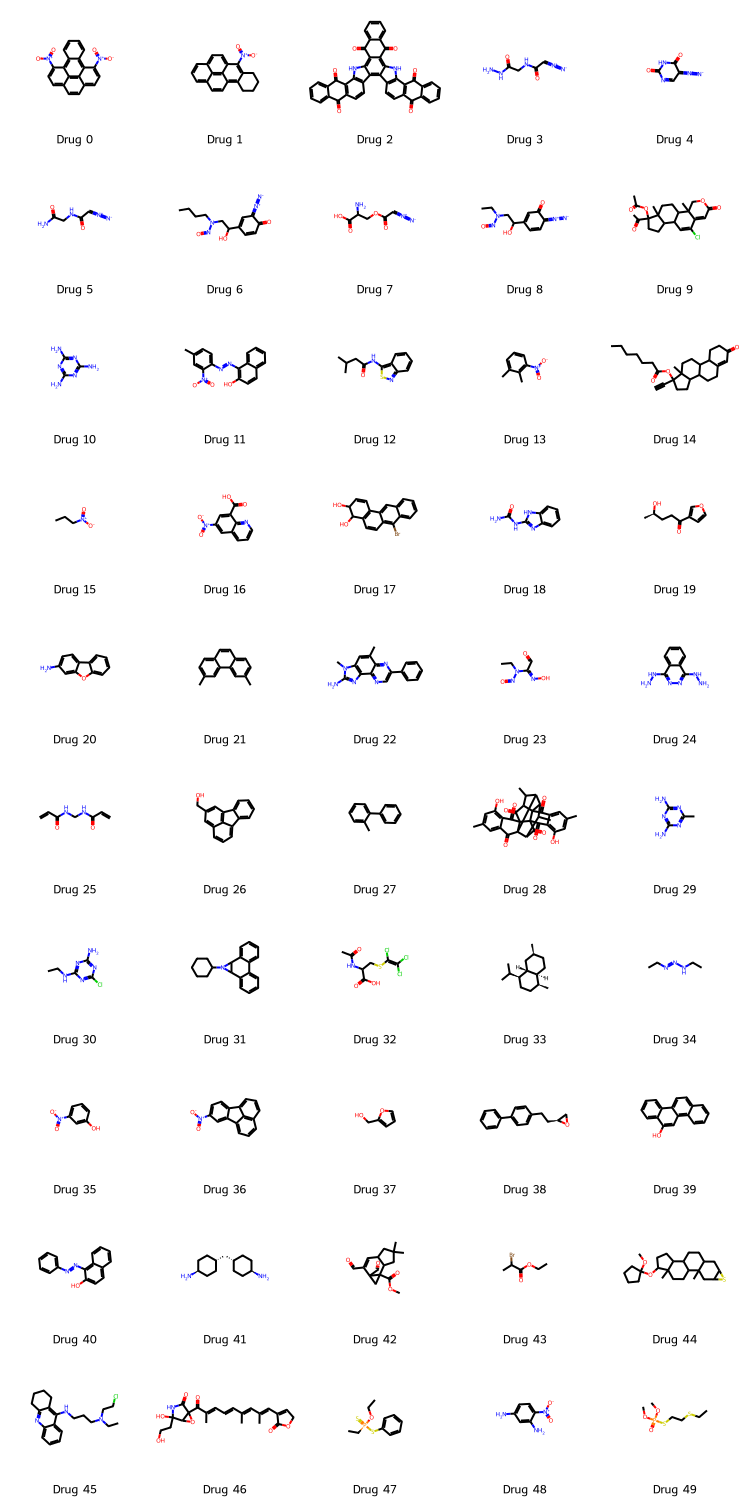

In [322]:
#representação das estruturas dos primeiros 50 compostos quimícos do dataset
PandasTools.FrameToGridImage(df,column= 'ROMol', molsPerRow=5,subImgSize=(150,150),legendsCol='ids')

### 3.1 - Análise da variável independente (Mutagenicidade)
</p>
<div style="text-align: justify">
O dataset utilizado possui uma distribuição equilibrada pois 54.64% das amostras apresentam características mutagénicas (3974 mutagénicas para 3299 não mutagénicas). Além disso, verificou-se que não possui nenhum valor NaN.
</div>
    

In [323]:
summary_Y = df['Y'].describe()
print(summary_Y)

count    7273.000000
mean        0.546405
std         0.497876
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Y, dtype: float64


In [324]:
freq_Y = df['Y'].value_counts()
print(freq_Y)

1    3974
0    3299
Name: Y, dtype: int64


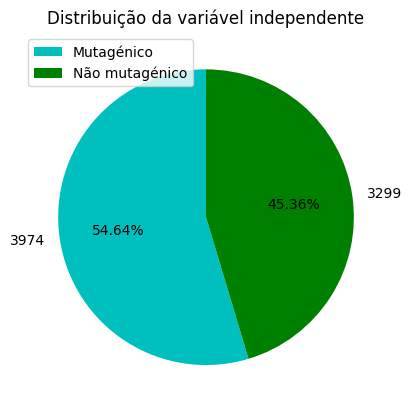

In [325]:
plt.pie(freq_Y, labels = freq_Y, colors=['c', 'g'], autopct='%1.2f%%', startangle=90)
plt.title('Distribuição da variável independente')
plt.legend(["Mutagénico","Não mutagénico"], loc='best')
plt.show()

In [326]:
# valores nulos - variável independente
if df['Y'].isna().any():
    print("A variável 'Y' (mutagenicidade) tem valores NA.")
else:
    print("A variável 'Y' (mutagenicidade) não tem valores NA.")

A variável 'Y' (mutagenicidade) não tem valores NA.


### 3.2 - Análise de Features
</p>
<div style="text-align: justify">
As features fornecidas correspondem aos descritores (também conhecidos como "características" ou "atributos") em dados SMILES, que são propriedades químicas calculadas a partir da estrutura molecular representada pelo SMILES. Essas propriedades são usadas para descrever a estrutura molecular de uma substância e podem ser usadas como entradas para modelos de previsão de propriedades químicas, como a toxicidade.</div>
</p>
<div style="text-align: justify">
Existem muitos descritores diferentes que podem ser calculados a partir de uma estrutura molecular, e alguns exemplos incluem o número de átomos de carbono, hidrogénio, nitrogéio e oxigénio, o peso molecular, o número de anéis aromáticos, a polaridade e a solubilidade em água. Os descritores são calculados através de algoritmos que transformam a estrutura molecular num conjunto numérico de características.</div>
</p>
<div style="text-align: justify">
Os descritores em dados SMILES são úteis para análise de dados químicos e modelação preditiva, podem ser usados para classificar e prever a atividade biológica ou a toxicidade de uma substância. Estes são uma ferramenta importante para o desenvolvimento de novos compostos farmacêuticos e para a avaliação da sua segurança e eficácia.</div>
</p>
<div style="text-align: justify">
No caso do dataset em análise foram fornecidos 208 descritores (exemplo:MolWT, LogP, MaxEStateIndex, etc...) que descrevem as propriedades de cada um dos 7273 compostos.
</div>

In [327]:
features = pd.read_csv(r"ames_features.csv")

In [328]:
features.shape

(7273, 208)

In [329]:
features.describe()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,...,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.00000,7273.000000,7273.000000
mean,9.362443,-0.451765,9.362443,0.349721,0.510130,242.568881,229.065451,242.196954,88.108483,0.000137,...,0.026674,0.011275,0.003162,0.003025,0.000412,0.012237,0.000550,0.00825,0.270727,0.017874
std,3.029246,1.227820,3.029246,0.396510,0.167265,107.926752,102.707469,107.731070,39.772440,0.011726,...,0.176611,0.111911,0.058548,0.054919,0.020307,0.114844,0.028719,0.09345,1.539449,0.138591
min,1.500000,-9.055860,1.500000,0.000000,0.036666,41.053000,36.033000,41.026550,14.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,6.209384,-0.846972,6.209384,0.075424,0.396894,165.148000,156.100000,165.039000,60.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,10.384028,-0.355799,10.384028,0.211296,0.510491,230.270000,218.173000,230.069140,84.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,11.488809,0.353001,11.488809,0.510718,0.621552,296.319000,280.241000,296.060400,108.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,17.286264,4.111111,17.286264,4.944445,0.935197,795.824000,766.923000,795.175400,314.000000,1.000000,...,3.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.00000,29.000000,2.000000


In [330]:
[str(x) for x in features.columns]

['MaxEStateIndex',
 'MinEStateIndex',
 'MaxAbsEStateIndex',
 'MinAbsEStateIndex',
 'qed',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_

### 3.2.1 - Análise das features 'Molecular Weight' e 'LogP' 

</p>
<div style="text-align: justify">
Um dos principais aspetos a ser analisado é o espaço químico de cada grupo de compostos quimícos. Este refere-se ao espaço físico-químico de todas as moléculas. Duas propriedades comumente usadas para explorar o espaço químico são o peso molecular (MW) e o Logaritmo de partição (LogP).</div>
</p>
<div style="text-align: justify">
O peso molecular (MW) é uma medida da massa de uma molécula, que permite obter informações sobre o tamanho e complexidade da molécula.</div>
</p>
<div style="text-align: justify">
O LogP determinada o coeficiente de partição entre a componente n-octanol e a água na molécula, sendo aceite como uma medida da lipofilicidade de uma molécula. Por sua vez, a lipofilicidade é um dos parâmetros mais importantes que determinam os comportamentos farmacocinéticos e farmacodinâmicos de um medicamento.</div>
</p>
<div style="text-align: justify">
Para explorar o espaço químico usando o MW e o LogP, é possível construir gráficos de dispersão com os valores dessas propriedades em cada composto químico do dataset. Este gráfico poderá revelar tendências e padrões na distribuição de moléculas no espaço químico.</div>

In [331]:
#apesar de os valores de MW e LogP estarem presente no dataset 'features', optamos por obter estes mesmos valores através do package RDKit
df['MW'] = df['ROMol'].map(Descriptors.MolWt)
df['logP'] = df['ROMol'].map(Descriptors.MolLogP)

#normalização dos valores
scaler = StandardScaler()
# df[['MW', 'logP']] = scaler.fit_transform(df[['MW', 'logP']])

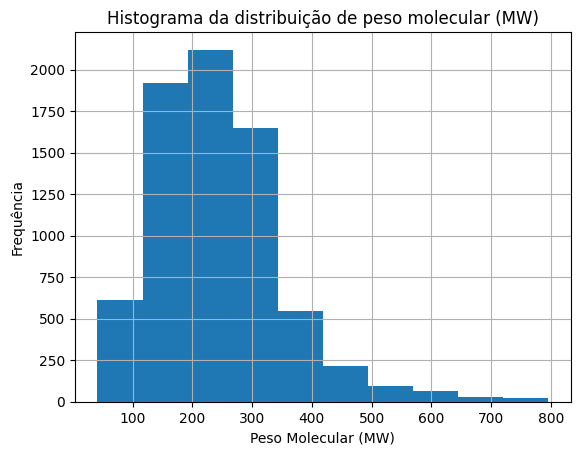

In [332]:
df['MW'].hist()
plt.title('Histograma da distribuição de peso molecular (MW)')
plt.xlabel('Peso Molecular (MW)')
plt.ylabel('Frequência')
plt.show()

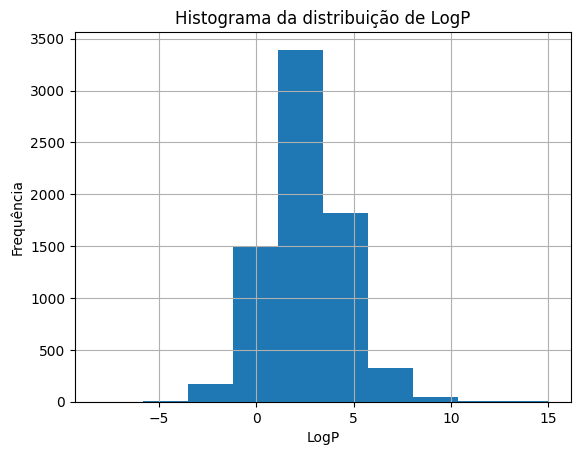

In [333]:
df['logP'].hist()
plt.title('Histograma da distribuição de LogP')
plt.xlabel('LogP')
plt.ylabel('Frequência')
plt.show()

</p>
<div style="text-align: justify">
Os histogramas das duas variáveis sugerem que a variável 'MW' (peso molecular) não segue uma disribuição normal, ao contrário da variável 'LogP' que aparenta seguir uma distribuição normal.</div>
</p>
<div style="text-align: justify">
No entanto, estas mesmas conclusões serão comprovadas mais à frente através de testes estatísticos.</div>

In [334]:
#Correlação entre MW e LogP
mw_logp_corr = df[['MW','logP']].corr()
print(mw_logp_corr)

            MW      logP
MW    1.000000  0.502693
logP  0.502693  1.000000


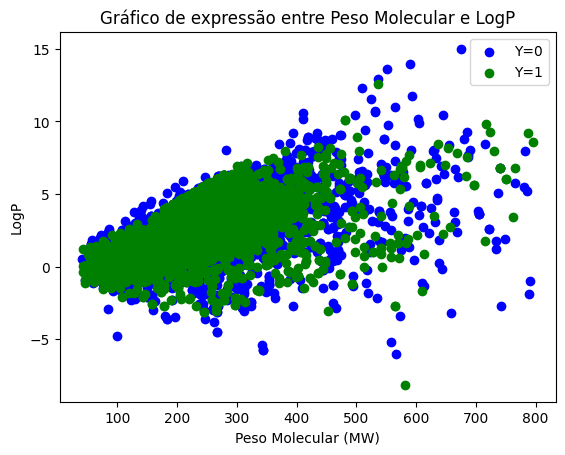

In [335]:
# Cria um dicionário de cores para os valores de Y
colors = {0: 'blue', 1: 'green'}

# Gera o gráfico de dispersão com cores diferentes para os pontos com valor 0 e 1 em Y
plt.scatter(df['MW'][df['Y']==0], df['logP'][df['Y']==0], c=colors[0], label='Y=0')
plt.scatter(df['MW'][df['Y']==1], df['logP'][df['Y']==1], c=colors[1], label='Y=1')
plt.xlabel('Peso Molecular (MW)')
plt.ylabel('LogP')
plt.title('Gráfico de expressão entre Peso Molecular e LogP')
plt.legend()
plt.show()

</p>
<div style="text-align: justify">
As duas variáveis (MW e LogP) apresentam uma correlação aproximada de 0.502, o que representa uma relação linear positiva moderada. Isto significa que, à medida que o peso molecular de um composto aumenta, o valor do seu logP também tende a aumentar, mesmo que alguma da variabilidade dos dados não seja explicada por esta relação linear. Estes resultados podem ser comparados com o gráfico de dispersão, que também apresenta uma relação linear entre as duas variáveis, embora esta não seja clara.</div>
</p>
<div style="text-align: justify">
Face aos resultados obtidos no gráfico de dispersão, os dois grupos de compostos químicos (mutagénicos e não mutagénicos) aparentam ter uma distribuição semelhante, logo, um espaço químico semelhante. Não são observados padrões ou tendências claros que possam distinguir os dois grupos de compostos químicos.</div>
</p>
<div style="text-align: justify">
Assim sendo, parece não haver uma relação clara entre a distribuição dos compostos químicos no espaço químico e a mutagenicidade dos compostos químicos.</div>
</p>
<div style="text-align: justify">
De modo a complementar o estudo da relação entre estas variáveis e a mutagenicidade, serão realizados alguns testes estatísticos nos pontos seguintes.</div>

### 3.2.2 - Peso Molecular vs Mutagenicidade
</p>
<div style="text-align: justify">
Aqui serão efetuados testes estatísticos para verificar se existe relação entre as variáveis de Peso Molecular e Mutagenicidade. Os testes estatísticos foram realizados para um <em>alpha</em> de 0.05.</div>
</p>
<div style="text-align: justify">
Os resultados apresentados parecem não corroborar as conclusões já discutidas anteriormente. Neste caso, através de testes de estatísticos, verificou-se uma diferença nos valores do peso molecular apresentados pelos compostos mutagénicos e não mutagénicos.</div>

In [336]:
#Descrição estatística do peso molecular para os compostos não mutagénicos
df['MW'][df['Y'] == 0].describe()

count    3299.000000
mean      243.336995
std       122.021677
min        41.053000
25%       152.149000
50%       221.303000
75%       307.267000
max       791.115000
Name: MW, dtype: float64

In [337]:
#Descrição estatística do peso molecular para os compostos mutagénicos
df['MW'][df['Y'] == 1].describe()

count    3974.000000
mean      241.931235
std        94.656045
min        42.037000
25%       178.187000
50%       237.280000
75%       289.203000
max       795.824000
Name: MW, dtype: float64

In [338]:
# teste à normalidade
stat, p = stats.shapiro(df['MW'])
print('Molecular Weight - teste à normalidade:\nStatistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('A variável "MW" (peso molecular) assume uma distribuição normal (falha em rejeitar H0)')
else:
    print('A variável "MW" (peso molecular) não assume uma distribuição normal (rejeita H0)')
print("\n")

# Mann-Whitney
stat, p = stats.mannwhitneyu(df['MW'][df['Y'] == 0], df['MW'][df['Y'] == 1])
print('Mann-Whitney U test:\nStatistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Não há diferença significativa entre as duas variáveis (falha em rejeitar H0)')
else:
    print('Há uma diferença significativa entre as duas variáveis (rejeita H0)')
print("\n")
    

Molecular Weight - teste à normalidade:
Statistics=0.930, p-value=0.000
A variável "MW" (peso molecular) não assume uma distribuição normal (rejeita H0)


Mann-Whitney U test:
Statistics=6259104.000, p-value=0.001
Há uma diferença significativa entre as duas variáveis (rejeita H0)




c:\Users\Paulo Seixal\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### 3.2.3 - LogP vs Mutagenicidade
</p>
<div style="text-align: justify">
Aqui serão efetuados testes estatísticos para verificar se existe relação entre as variáveis de LogP e Mutagenicidade.</div>
</p>
<div style="text-align: justify">
Novamente, os resultados apresentados parecem não corroborar as conclusões já discutidas anteriormente. Neste caso, através de testes estatísticos, verificou-se uma diferença nos valores do logP apresentados pelos compostos mutagénicos e não mutagénicos.</div>

In [339]:
#Descrição estatística do logP para os compostos não mutagénicos
df['logP'][df['Y'] == 0].describe()

count    3299.000000
mean        2.434715
std         2.149808
min        -6.054700
25%         1.102850
50%         2.338200
75%         3.655450
max        14.998800
Name: logP, dtype: float64

In [340]:
#Descrição estatística do logP para os compostos mutagénicos
df['logP'][df['Y'] == 1].describe()

count    3974.000000
mean        2.562309
std         1.886056
min        -8.161100
25%         1.295450
50%         2.475310
75%         3.822905
max        12.605800
Name: logP, dtype: float64

In [341]:
# teste à normalidade
stat, p = stats.shapiro(df['logP'])
print('LogP - Teste à normalidade:\nStatistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('A variável logP não assume uma distribuição normal (falha em rejeitar H0)')
else:
    print('A variável logP assume uma distribuição normal (falha em rejeitar H0)')
print("\n")

# T-Test
stat, p = stats.ttest_ind(df['logP'][df['Y'] == 0], df['logP'][df['Y'] == 1])
print('T-Test:\nStatistics=%.3f, p-value=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Não existe diferença significante entre as duas variáveis (falha em rejeitar H0)')
else:
    print('Existe uma diferença significante entre as duas variáveis (rejeita H0)')
print("\n")

LogP - Teste à normalidade:
Statistics=0.989, p-value=0.000
A variável logP assume uma distribuição normal (falha em rejeitar H0)


T-Test:
Statistics=-2.695, p-value=0.007
Existe uma diferença significante entre as duas variáveis (rejeita H0)




c:\Users\Paulo Seixal\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### 3.2.4 - Plotting
</p>
<div style="text-align: justify">
Nos gráficos boxplot abaixo apresentados, os valores do peso molecular apresentam um ligeiro desequilíbrio na distribuição de valores entre compostos mutagénicos e não mutagénicos.</div>
</p>
<div style="text-align: justify">
No entanto, os valores de LogP apresentam uma distribuição de valores equilibrada, independentemente da mutagenicidade do composto.</div>

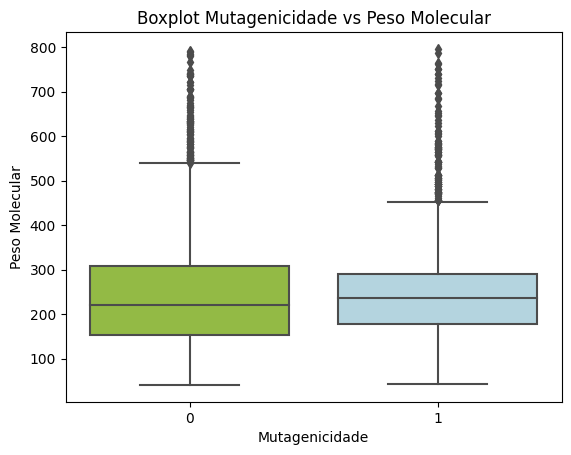

In [342]:
# criação do boxplot

my_palette = ["#9ACD32", "#ADD8E6"]
sns.boxplot(x='Y', y='MW', data=df,palette=my_palette)

# Título e legendas
plt.title('Boxplot Mutagenicidade vs Peso Molecular')
plt.xlabel('Mutagenicidade')
plt.ylabel('Peso Molecular')


plt.show()

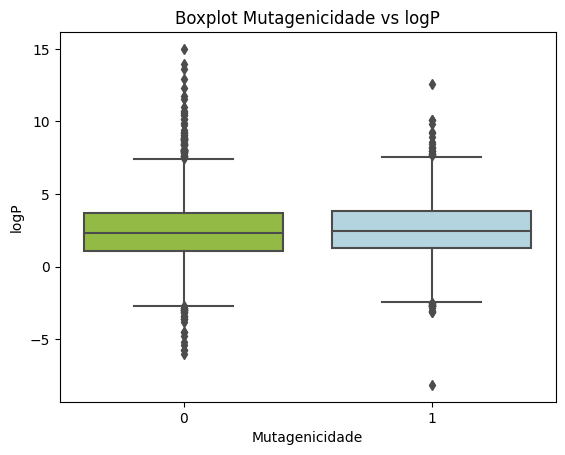

In [343]:
# Criar o boxplot

my_palette = ["#9ACD32", "#ADD8E6"]
sns.boxplot(x='Y', y='logP', data=df, palette=my_palette)

# Título e legendas
plt.title('Boxplot Mutagenicidade vs logP')
plt.xlabel('Mutagenicidade')
plt.ylabel('logP')

plt.show()

### 4 - Seleção de features
</p>
<div style="text-align: justify">
A seleção de features pode ser particularmente importante devido à elevada dimensionalide dos dados. O conjunto dos dados original conta com 7273 compostos químicos, cada um descrito por 208 features.</div>
</p>
<div style="text-align: justify">
Posto isto, algumas dessas features podem ser irrelevantes ou redundantes para prever a mutagenicidade, e incluí-las só aumentaria a complexidade computacional sem melhorar a precisão.</div>
</p>
<div style="text-align: justify">
Assim sendo, foram usados métodos de seleção de features do sklearn, para identificar as que serão mais informativas e relevantes para prever a mutagenicidade no dataset.</div>
<p>
<div style="text-align: justify">
Desta forma, decidiu-se efetuar uma seleção do percentil 5 às features com melhor performance tendo como base o score obtido pelo teste ANOVA, aplicado através do método <code>SelectPercentile(f_classif, percentile=5)</code>
</div>

In [344]:
# separar features e labels(y)
X = features
y = df['Y']

# SelectPercentile
selector = SelectPercentile(f_classif, percentile=5)  
X_new = selector.fit_transform(X, y)

# print features selecionadas
print(X.columns[selector.get_support()])

Index(['HallKierAlpha', 'SMR_VSA5', 'SlogP_VSA5', 'SlogP_VSA8', 'VSA_EState8',
       'NumAromaticCarbocycles', 'NumAromaticRings', 'RingCount', 'fr_benzene',
       'fr_nitro', 'fr_nitro_arom_nonortho'],
      dtype='object')


c:\Users\Paulo Seixal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 67  80 195] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\Paulo Seixal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [345]:
# Novo dataframe com as features selecionadas
perc5_y = pd.concat([df['Y'], features['HallKierAlpha'], features['SMR_VSA5'], features['SlogP_VSA5'], features['SlogP_VSA8'], features['VSA_EState8'],
       features['NumAromaticCarbocycles'], features['NumAromaticRings'], features['RingCount'], features['fr_benzene'],
       features['fr_nitro'], features['fr_nitro_arom_nonortho']], axis=1)
perc5_y


,Y,HallKierAlpha,SMR_VSA5,SlogP_VSA5,SlogP_VSA8,VSA_EState8,NumAromaticCarbocycles,NumAromaticRings,RingCount,fr_benzene,fr_nitro,fr_nitro_arom_nonortho
0,1,-3.80,0.000000,0.000000,43.089794,0.000000,5.0,5.0,5.0,5.0,2.0,2.0
1,1,-2.68,25.683287,23.968546,32.317345,0.000000,4.0,4.0,5.0,4.0,1.0,0.0
2,0,-7.06,0.000000,0.000000,108.246390,0.000000,9.0,11.0,11.0,9.0,0.0,0.0
3,1,-1.72,0.000000,0.000000,5.531129,-0.248657,0.0,0.0,0.0,0.0,0.0,0.0
4,1,-1.81,0.000000,0.000000,5.531129,0.000000,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7268,0,-0.08,71.131950,71.131950,0.000000,3.727293,0.0,0.0,0.0,0.0,0.0,0.0
7269,0,-1.56,25.683287,30.389368,0.000000,2.303843,2.0,2.0,2.0,2.0,0.0,0.0
7270,0,0.18,18.742958,13.847474,0.000000,4.819040,1.0,1.0,1.0,1.0,0.0,0.0
7271,0,-1.05,39.716820,33.612854,0.000000,9.451552,0.0,0.0,1.0,0.0,0.0,0.0


In [346]:
#normalização dos dados

# lista com colunas a normalizar
cols_to_scale = [col for col in perc5_y.columns if col != 'Y']

# criar novo df só com essas colunas
df_to_scale = perc5_y[cols_to_scale]

# normalizar
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_to_scale)

# converter para dataframe
df_scaled = pd.DataFrame(scaled_data, columns=cols_to_scale)

# concatenar com a coluna da variável independente
perc5_y_scaled = pd.concat([df['Y'], df_scaled], axis=1)
perc5_y_scaled

,Y,HallKierAlpha,SMR_VSA5,SlogP_VSA5,SlogP_VSA8,VSA_EState8,NumAromaticCarbocycles,NumAromaticRings,RingCount,fr_benzene,fr_nitro,fr_nitro_arom_nonortho
0,1,-1.932381,-0.742669,-0.780329,3.014031,-0.683103,3.015790,2.579185,1.807559,3.014997,3.754588,5.520171
1,1,-0.952377,0.385801,0.336479,2.100532,-0.683103,2.217586,1.839617,1.807559,2.217003,1.694140,-0.276566
2,0,-4.784895,-0.742669,-0.780329,8.539277,-0.683103,6.208604,7.016595,5.528584,6.206973,-0.366308,-0.276566
3,1,-0.112373,-0.742669,-0.780329,-0.170926,-0.766481,-0.975229,-1.118657,-1.293294,-0.974972,-0.366308,-0.276566
4,1,-0.191123,-0.742669,-0.780329,-0.170926,-0.683103,-0.975229,-1.118657,-0.673124,-0.974972,-0.366308,-0.276566
...,...,...,...,...,...,...,...,...,...,...,...,...
7268,0,1.322634,2.382718,2.534045,-0.639963,0.566711,-0.975229,-1.118657,-1.293294,-0.974972,-0.366308,-0.276566
7269,0,0.027628,0.385801,0.635655,-0.639963,0.089408,0.621179,0.360480,-0.052953,0.621015,-0.366308,-0.276566
7270,0,1.550135,0.080857,-0.135110,-0.639963,0.932789,-0.177025,-0.379089,-0.673124,-0.176978,-0.366308,-0.276566
7271,0,0.473880,1.002404,0.785853,-0.639963,2.486134,-0.975229,-1.118657,-0.673124,-0.974972,-0.366308,-0.276566


<div style="text-align: justify">
Através do método <i>SelecPercentile</i> do <i>sklearn</i> foram selecionadas as seguintes features:
<ul>    
<li> <b>HallKierAlpha</b>: representa a densidade de eletrões em cada átomo de uma molécula. É usado para prever a reatividade química e a estabilidade de compostos. </li>
<li> <b>SMR_VSA5</b>: mede a área superficial molecular relativa (SMR) de uma molécula em torno de um átomo específico. É usado para prever a solubilidade e a atividade biológica de compostos.</li>
<li> <b>SlogP_VSA5</b>: mede a contribuição de cada grupo de átomos de uma molécula para a partição octanol-água (logP). É usado para prever a solubilidade e a permeabilidade do composto através de membranas biológicas.</li>
<li> <b>SlogP_VSA8</b>: semelhante ao SlogP_VSA5, mas calculado para uma raio de 8 Å à volta de um átomo específico.</li>
<li> <b>VSA_EState8</b>: mede a carga eletrostática da molécula em torno de um átomo específico. É usado para prever a atividade biológica de compostos.</li>
<li> <b>NumAromaticCarbocycles</b>: conta o número de ciclos aromáticos numa molécula, que contêm apenas átomos de carbono. É usado para identificar compostos com propriedades aromáticas.</li>
<li> <b>NumAromaticRings</b>: semelhante ao NumAromaticCarbocycles, mas que conta o número total de anéis aromáticos de uma molécula, e não só os que contêm apenas átomos de carbono.</li>
<li> <b>RingCount</b>: conta o número total de anéis de uma molécula, independentemente de serem aromáticos ou não.</li>
<li> <b>fr_benzene</b>: conta o número de anéis de benzeno de uma molécula.</li>
<li> <b>fr_nitro</b>: conta o número de grupos NO2 de uma molécula.</li>
<li> <b>fr_nitro_arom_nonortho</b> conta o número de grupos nitro em anéis aromáticos que não estão na posição <em>orto</em> .</li>
</ul>
</div>

### 4.1 - Pré-processamento e análise das features selecionadas

Após a seleção das *features* foi necessário o processamento e posterior análise das mesmas.

In [347]:
perc5_y.describe()

,Y,HallKierAlpha,SMR_VSA5,SlogP_VSA5,SlogP_VSA8,VSA_EState8,NumAromaticCarbocycles,NumAromaticRings,RingCount,fr_benzene,fr_nitro,fr_nitro_arom_nonortho
count,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000
mean,0.546405,-1.591574,16.902695,16.747155,7.546773,2.037204,1.221779,1.512581,2.085384,1.221779,0.177781,0.095421
std,0.497876,1.142930,22.760971,21.463131,11.793333,2.982485,1.252899,1.352233,1.612570,1.253229,0.485365,0.345045
min,0.000000,-7.400000,-0.061902,0.000000,0.000000,-4.128889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-2.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,-1.630000,10.937325,11.126903,0.000000,0.904612,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000
75%,1.000000,-0.830000,24.539800,23.334835,11.126903,3.203314,2.000000,2.000000,3.000000,2.000000,0.000000,0.000000
max,1.000000,3.480000,232.155410,232.155410,108.246390,28.341402,9.000000,11.000000,11.000000,9.000000,6.000000,4.000000


In [348]:
# verificar valores NA das features

for col in perc5_y_scaled.columns:
    if perc5_y_scaled[col].isna().sum() > 0:
        print(f" A variável'{col}' tem {perc5_y_scaled[col].isna().sum()} valores NA\n")
    else:
        print(f"A variável '{col}' não tem valores NA\n")

A variável 'Y' não tem valores NA

A variável 'HallKierAlpha' não tem valores NA

A variável 'SMR_VSA5' não tem valores NA

A variável 'SlogP_VSA5' não tem valores NA

A variável 'SlogP_VSA8' não tem valores NA

A variável 'VSA_EState8' não tem valores NA

A variável 'NumAromaticCarbocycles' não tem valores NA

A variável 'NumAromaticRings' não tem valores NA

A variável 'RingCount' não tem valores NA

A variável 'fr_benzene' não tem valores NA

A variável 'fr_nitro' não tem valores NA

A variável 'fr_nitro_arom_nonortho' não tem valores NA



<div style="text-align: justify">
Depois de se verificar que nenhuma das <em>features</em> selecionadas apresenta valores NA, procedeu-se à realização de alguns testes estatísticos de forma a estabelecer uma comparação entre os compostos mutagénicos e não mutagénicos. Os testes foram realizados para um <em>alpha</em> de 0.05
</div>

In [349]:
print('***TESTES À NORMALIDADE***\n')
for i in perc5_y_scaled.columns:
# Shapiro-Wilk test
    stat, p = stats.shapiro(perc5_y_scaled[i])
    print(f'Teste à normalidade da variável "{i}":\nStatistics=%.3f, p-value=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print(f'"{i}", não assume uma distribuição normal (falha em rejeitar H0)\n')
    else:
        print(f'"{i}", assume uma distribuição normal (rejeita H0)\n')
print("\n")

print('--------------------------------------------------------------------------------------------\n')

significant = dict()

print('***T-TEST***\n')
for i in perc5_y_scaled.columns:
    print(i, 'vs Mutagenicity')

# perform a Mann-Whitney U test
    stat, p = stats.ttest_ind(perc5_y_scaled[i][perc5_y_scaled['Y'] == 0], perc5_y_scaled[i][perc5_y_scaled['Y'] == 1])
    print('T-test:\nStatistics=%.3f, p-value=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Não há uma diferença significativa entre as duas variáveis (falha em rejeitar H0)\n')
    else:
        print('Há uma diferença significativa entre as duas variáveis (rejeita H0)\n')


print("\n") 


***TESTES À NORMALIDADE***

Teste à normalidade da variável "Y":
Statistics=0.634, p-value=0.000
"Y", assume uma distribuição normal (rejeita H0)

Teste à normalidade da variável "HallKierAlpha":
Statistics=0.992, p-value=0.000
"HallKierAlpha", assume uma distribuição normal (rejeita H0)

Teste à normalidade da variável "SMR_VSA5":
Statistics=0.715, p-value=0.000
"SMR_VSA5", assume uma distribuição normal (rejeita H0)

Teste à normalidade da variável "SlogP_VSA5":
Statistics=0.733, p-value=0.000
"SlogP_VSA5", assume uma distribuição normal (rejeita H0)

Teste à normalidade da variável "SlogP_VSA8":
Statistics=0.692, p-value=0.000
"SlogP_VSA8", assume uma distribuição normal (rejeita H0)

Teste à normalidade da variável "VSA_EState8":
Statistics=0.755, p-value=0.000
"VSA_EState8", assume uma distribuição normal (rejeita H0)

Teste à normalidade da variável "NumAromaticCarbocycles":
Statistics=0.843, p-value=0.000
"NumAromaticCarbocycles", assume uma distribuição normal (rejeita H0)

Tes

c:\Users\Paulo Seixal\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\Paulo Seixal\AppData\Local\Temp\ipykernel_9808\2964279599.py:22: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  stat, p = stats.ttest_ind(top10_y_scaled[i][top10_y_scaled['Y'] == 0], top10_y_scaled[i][top10_y_scaled['Y'] == 1])


<div style="text-align: justify">
Nos testes estatísticos realizados verificou-se que todas as <em>features</em> seguem uma distribuição normal. Verificou-se também que, após realização do t-test, todas as <em>features</em> apresentam uma diferença significativa nos seus valores, ao comparar compostos mutagénicos e não mutagénicos.</div>

Estes resultados foram de encontro ao esperado dada à aplicação do método <em>SelectPercentile</em> aplicado ao dataframe.
</p>
<div style="text-align: justify">
Foi possível concluir que todas estas features poderão servir de base para explicar e prever a mutagenicidade entre compostos.</div>

### 4.2 - Plotting
</p>
<div style="text-align: justify">
Depois dos testes estatísticos, foram também construídos gráficos de apoio à análise dos resultados anteriores. Neste caso utilizaram-se boxplots para cada <i>feature</i>, onde serão comparadas as suas ditribuições de valores entre compostos mutagénicos e não mutagénicos.</div>

HallKierAlpha vs Mutagenicidade


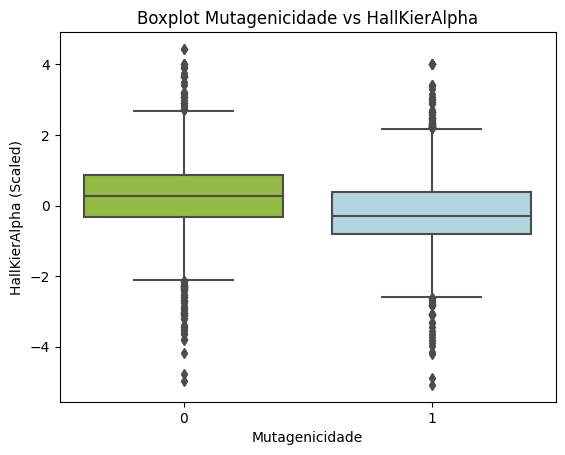

SMR_VSA5 vs Mutagenicidade


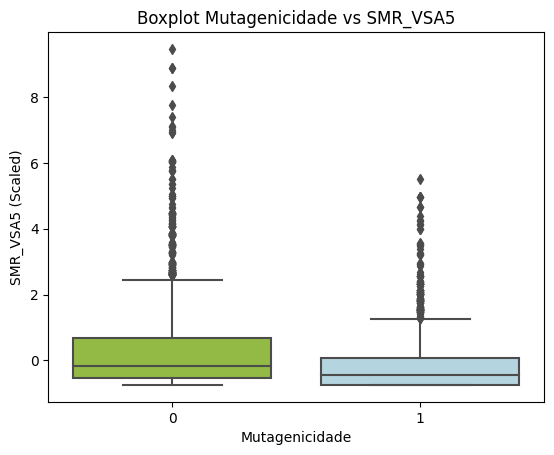

SlogP_VSA5 vs Mutagenicidade


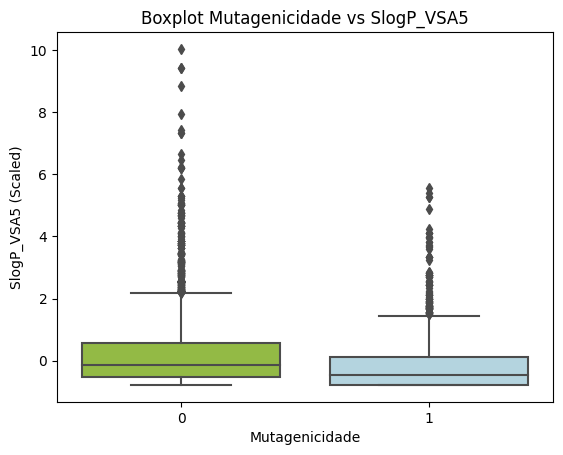

SlogP_VSA8 vs Mutagenicidade


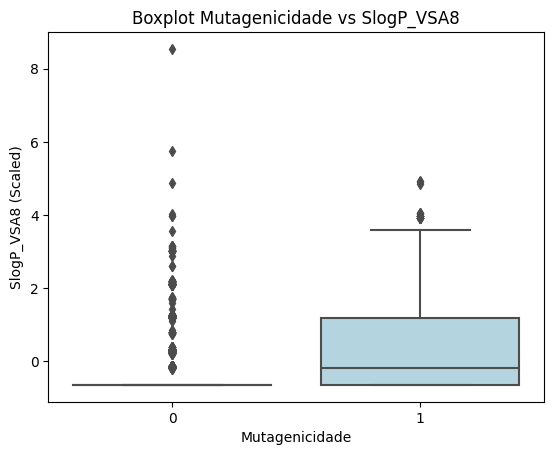

VSA_EState8 vs Mutagenicidade


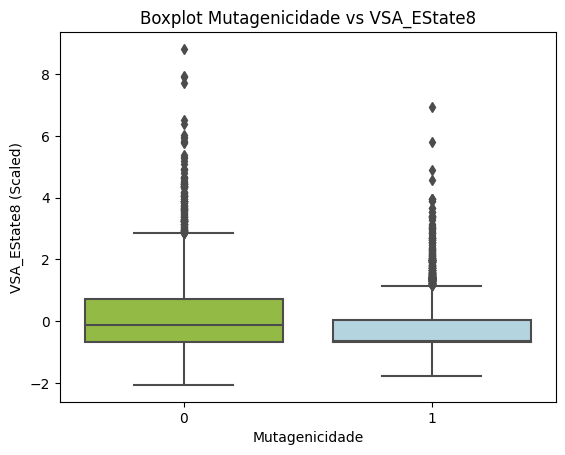

NumAromaticCarbocycles vs Mutagenicidade


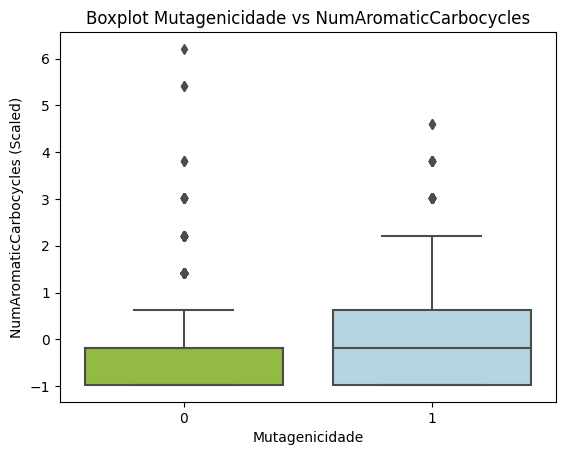

NumAromaticRings vs Mutagenicidade


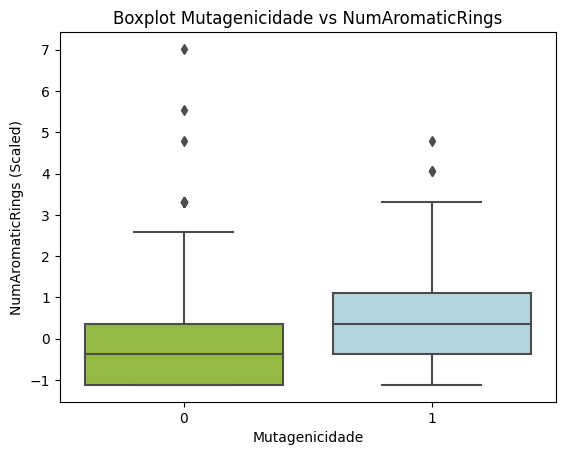

RingCount vs Mutagenicidade


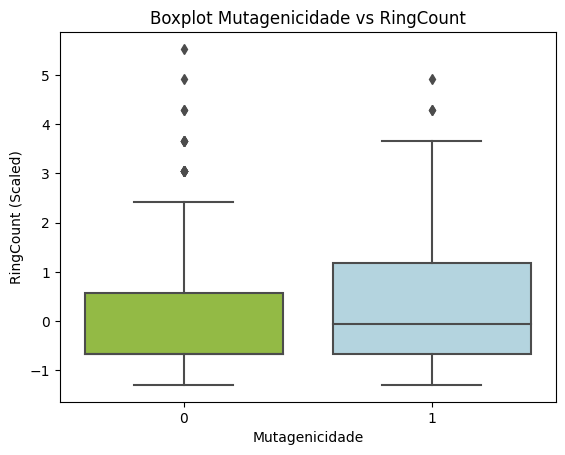

fr_benzene vs Mutagenicidade


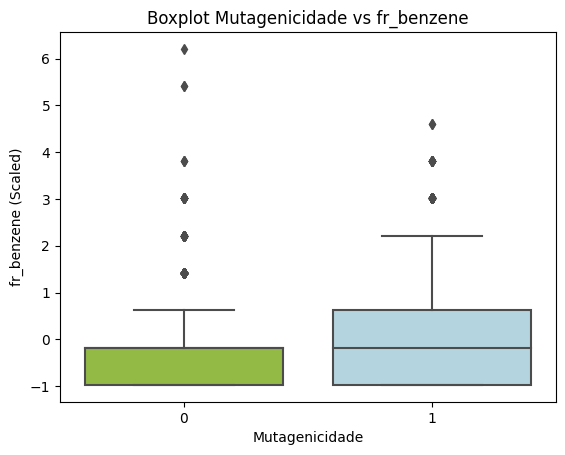

fr_nitro vs Mutagenicidade


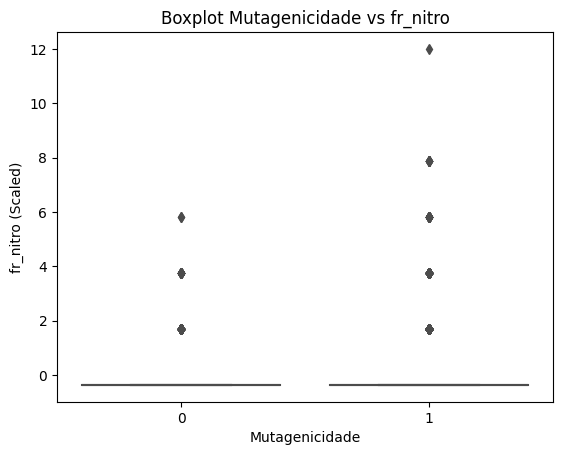

fr_nitro_arom_nonortho vs Mutagenicidade


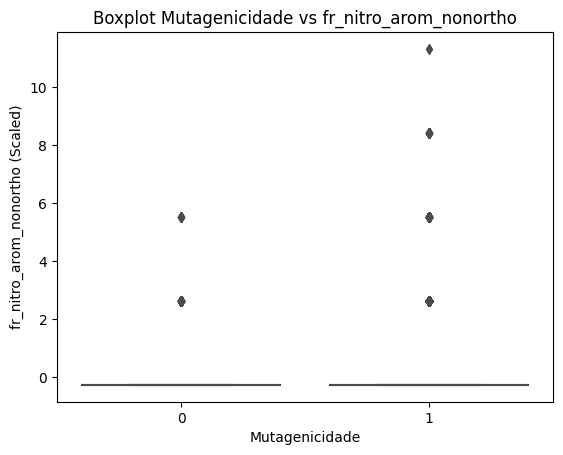

In [350]:
my_palette = ["#9ACD32", "#ADD8E6"]
for i in perc5_y_scaled.columns:
    if i != 'Y':
        print(i, 'vs Mutagenicidade')
    # criar o boxplot
        sns.boxplot(x='Y', y=i, data=perc5_y_scaled,palette=my_palette)

    # título e legendas
        plt.title('Boxplot Mutagenicidade vs ' + i)
        plt.xlabel('Mutagenicidade')
        plt.ylabel(f'{i} (Scaled)')

        plt.show()


</p>
<div style="text-align: justify">
Os resultados apresentados corroboram as conclusões já retiradas dos testes estatísticos anteriores. Há uma diferença na distribuição de valores de cada <i>feature</i> entre compostos mutagénicos e não mutagénicos.</div>
</p>
<div style="text-align: justify">
No entanto, há algumas dúvidas quanto às <i>features</i>,  <b>fr_nitro</b> e <b>fr_nitro_arom_nonortho</b>, onde os boxplots aparentam ter apenas outliers.</div> </div>

### 4.3 - Correlação entre features
</p>
<div style="text-align: justify">
Uma etapa importante na análise das <i>features</i> é o estudo da correlação entre as mesmas. Estabelecer correlações entre <i>features</i> torna-se importante pois permite identificar padrões e relações entre os dados, que ajudam à interpretação do significado biológico destas mesmas <i>features</i>. </div>

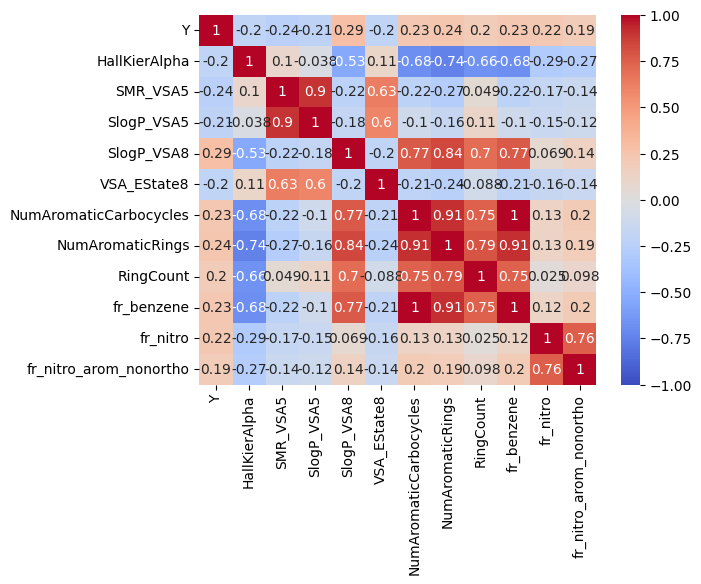

In [351]:
# criar matriz de correlação
features_corr = perc5_y_scaled.corr()

# criação do heatmap
sns.heatmap(features_corr, cmap='coolwarm', annot=True, vmin=-1, vmax=1)

plt.show()

</p>
<div style="text-align: justify">
Os resultados do heatmap de correlações apresentam uma clara correlação positiva entre os grupo de features <b>NumAromaticCarbocycles</b>; <b>NumAromaticRings</b>; <b>RingCount</b>; <b>fr_benzene</b>; e <b>SlogP_VSA8</b>, com valores de correlação entre 0.75 e 0.91.</div> 
</p>
<div style="text-align: justify">
Tratando-se de <i>features</i> relacionadas com o número e tipo de anéis que compõem a estrutura da molécula, faz todo o sentido que se verifique uma correlação positiva.</div>
</p>
<div style="text-align: justify">
Relativamente à variável independente (mutagenicidade), embora não exista nenhuma correlação óbvia, existem algumas features com correlação positiva moderada. São elas: <b>SlogP_VSA8</b>; <b>NumAromaticCarbocycles</b>; <b>NumAromaticRings</b>; <b>RingCount</b>; <b>fr_benzene</b>; <b>fr_nitro</b> e <b>fr_nitro_arom_northo</b>.</div>

### 4.4 - Análise de Componentes Principais (PCA) 
</p>
<div style="text-align: justify">
Após a seleção das features, procedeu-se à redução de dimensionalidade do dataframe resultante ("df_scaled"), de modo a obter um conjunto menor e independente de variáveis chamadas de componentes principais. </div>
</p>
<div style="text-align: justify">
O PCA foi realizado para uma redução de até três PCs que explicam 83% da variância dos dados.
Os dados obtidos podem ser visualizados no gráfico bidimensional que utiliza os dois componentes principais como eixo.</div>



Var. explicada: [0.46404387 0.22072711 0.14853124]
Soma: 83.33022189848211 %
[[46.40438693  0.          0.        ]
 [ 0.         22.07271098  0.        ]
 [ 0.          0.         14.85312399]]


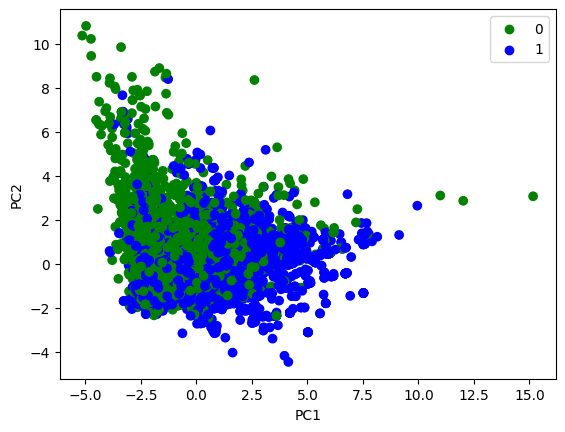

In [352]:
# PCA (df_scaled apresenta apenas as features selecionadas num dos tópicos anteriores, já normalizadas)
pca = PCA(n_components=3)
pca.fit(df_scaled)

# determinar var
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
print('Var. explicada: %s'% str(pca.explained_variance_ratio_))
print('Soma:', sum(pca.explained_variance_ratio_) * 100, '%')


#obter as percentagens de variabilidade explicadas por cada PC
varia_exp = pca.explained_variance_ratio_
matriz_var_exp = np.diag(varia_exp*100)
print(matriz_var_exp)

# três primeiros PCs
pca_scores = pca.transform(df_scaled)[:, :3]

# mapa de cores para o plot
data_colors = {0: 'green', 1: 'blue'}
colors = [data_colors[t] for t in df['Y']]

# plot
plt.scatter(pca_scores[:, 0], pca_scores[:, 1], c=colors)
plt.xlabel('PC1')
plt.ylabel('PC2')

# legenda
handles = []
labels = []
for data_type, color in data_colors.items():
    handles.append(plt.scatter([], [], c=color))
    labels.append(data_type)
plt.legend(handles, labels, loc='upper right')

No gráfico PCA, podemos observar que não há uma clara separação dos compostos, tendo em conta a sua mutagenicidade, indicando que a partir dos dados inseridos, não existem diferenças claras que permitam distinguir os compostos. 

Ainda assim optou-se ainda por fazer uma visualização dos mesmos dados, desta vez a partir de 3 componentes, de onde se podem tirar as mesmas conclusões.

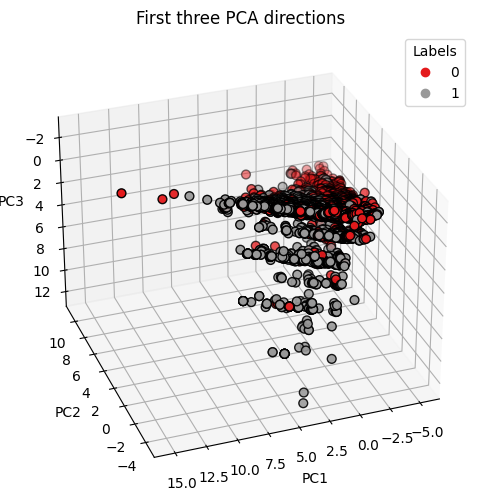

In [422]:
# criação do plot
fig = plt.figure(1, figsize=(8, 6))

ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

scatter = ax.scatter(
    pca_scores[:, 0],
    pca_scores[:, 1],
    pca_scores[:, 2],
    c=y,
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

# Título e legendas
ax.set_title("First three PCA directions")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")


legend = ax.legend(*scatter.legend_elements(), title="Labels")


plt.show()


Cada linha na matriz ```pca.components_``` representa um componente principal, e cada coluna representa uma *feature*. O valor em cada posição representa o peso da *feature* no componente principal correspondente.

Para ter uma ideia de quais serão *features* mais associadas a cada PC, examinaram-se os valores dos pesos das *features* em cada linha. As *features* com os valores absolutos mais altos numa determinada linha são aquelas que contribuem mais para esse componente principal. Neste caso, serão as *features*: **NumAromaticRings**, **SlogP_VSA5**, e **fr_nitro**

In [354]:
# nomes das features
feature_names = list(df_scaled.columns.values)


for i, pc in enumerate(pca.components_):
    print(f"Principal component {i+1}:")
    
    # obter pesos das features
    pc_weights = dict(zip(feature_names, pc))
    
    # ordenar features pelo peso
    pc_weights_sorted = sorted(pc_weights.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # top 5 features
    for j in range(5):
        feature, weight = pc_weights_sorted[j]
        print(f"\t{feature}: {weight:.3f}")
    
    print()


Principal component 1:
	NumAromaticRings: 0.425
	NumAromaticCarbocycles: 0.416
	fr_benzene: 0.416
	SlogP_VSA8: 0.374
	RingCount: 0.355

Principal component 2:
	SlogP_VSA5: 0.566
	SMR_VSA5: 0.548
	VSA_EState8: 0.449
	RingCount: 0.243
	fr_nitro: -0.212

Principal component 3:
	fr_nitro: 0.659
	fr_nitro_arom_nonortho: 0.648
	SlogP_VSA5: 0.190
	SMR_VSA5: 0.183
	HallKierAlpha: -0.156



### 4.5 - Clustering (Distância de Manhattan)
</p>
<div style="text-align: justify">
Tendo em conta o elevado número de compostos químicos em análise, é necessário agrupá-los com base em suas características ou atributos comuns. 

Tratando-se de um dataset com milhares de compostos, o uso de clustering hierarquico poderá não ser a melhor opção, uma vez que se torna demasiado pesado computacionalmente e será dificl conseguir fazer algum tipo de interpretação de resultados, dada a elevada dimensão do dataset. 

O dendograma abaixo apresentado torna-se, então, demasiado denso para retirar alguma conslusão. 
</div>

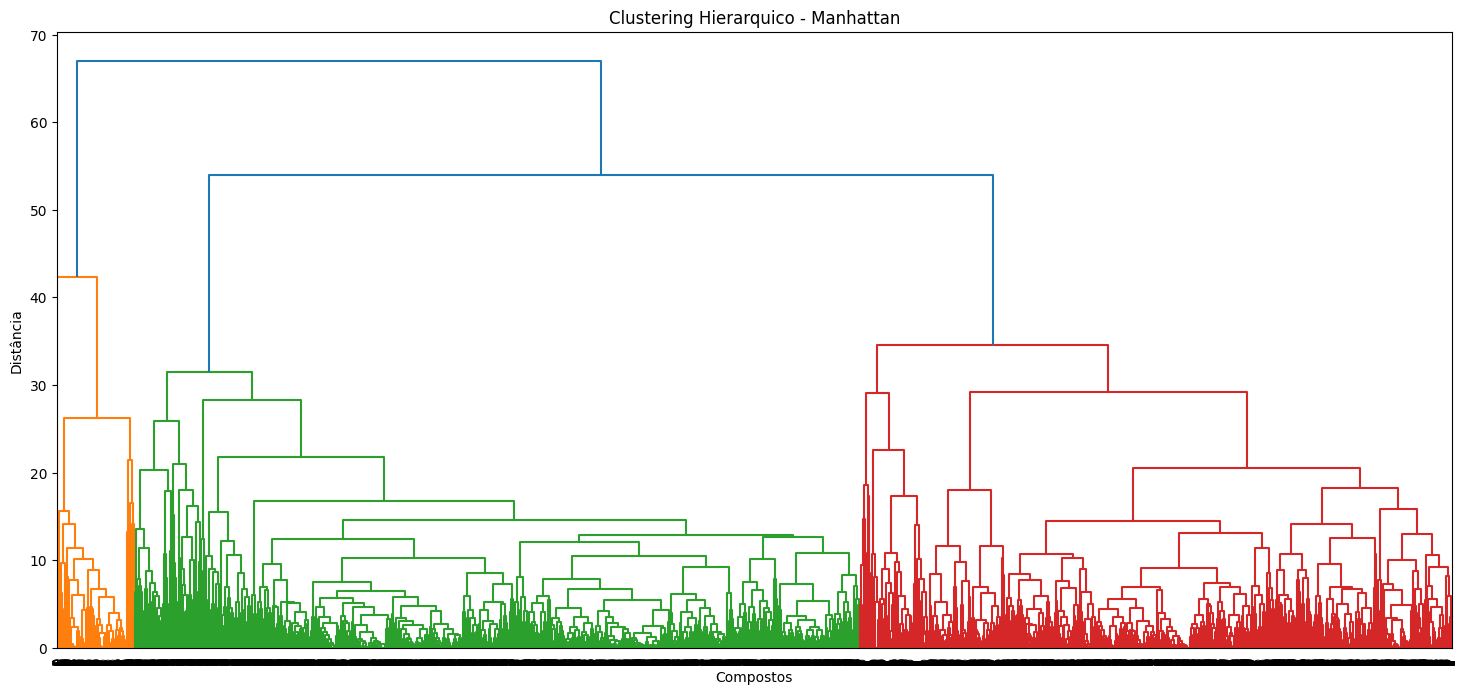

In [355]:
df_copy = df.copy()
df_copy.reset_index(drop=True, inplace=True)
# Clustering hierarquico com distância de manhattan
Z = linkage(df_scaled, method='complete', metric='cityblock')

# dendograma
plt.figure(figsize=(18, 8))
dendrogram(Z, 
           labels=df_copy['Y'].values, 
           orientation='top', 
           leaf_font_size=8)

# mapa de cores
data_colors = {0: 'blue', 1: 'green'}
ax = plt.gca()


plt.title('Clustering Hierarquico - Manhattan')
plt.xlabel('Compostos')
plt.ylabel('Distância')
plt.show()


In [356]:
# Criação dos clusters através do método fcluster 
k = 2 # número de clusters
clusters = fcluster(Z, k, criterion='maxclust')
y_true = df_copy['Y']

pd.crosstab(df_copy['Y'].values,columns=y_true, rownames=['clusters'])

Y,0,1
clusters,,
0,3299,0
1,0,3974


A título de exemplo, decidiu-se efetuar uma análise de uma amostra composta por 100 compostos, construida a partir do dataset anterior.

Nos resultados abaixo apresentados já se torna possível uma melhor interpretação dos mesmos. É possível observar uma separação dos compostos mutagénicos e não mutagénicos, em dois clusters distintos, onde existe uma maior presença dos compostos mutagénicos (1) no cluster verde, e não mutagénicos (0) no cluster laranja.

In [357]:
#Adicionar a variável independente Y
df_scaled_y = pd.concat([df_scaled, df['Y']], axis=1)

In [358]:
#Criação de uma amostra aleatória de 100 compostos
sampled_data = df_scaled_y.sample(n=100, random_state=42)


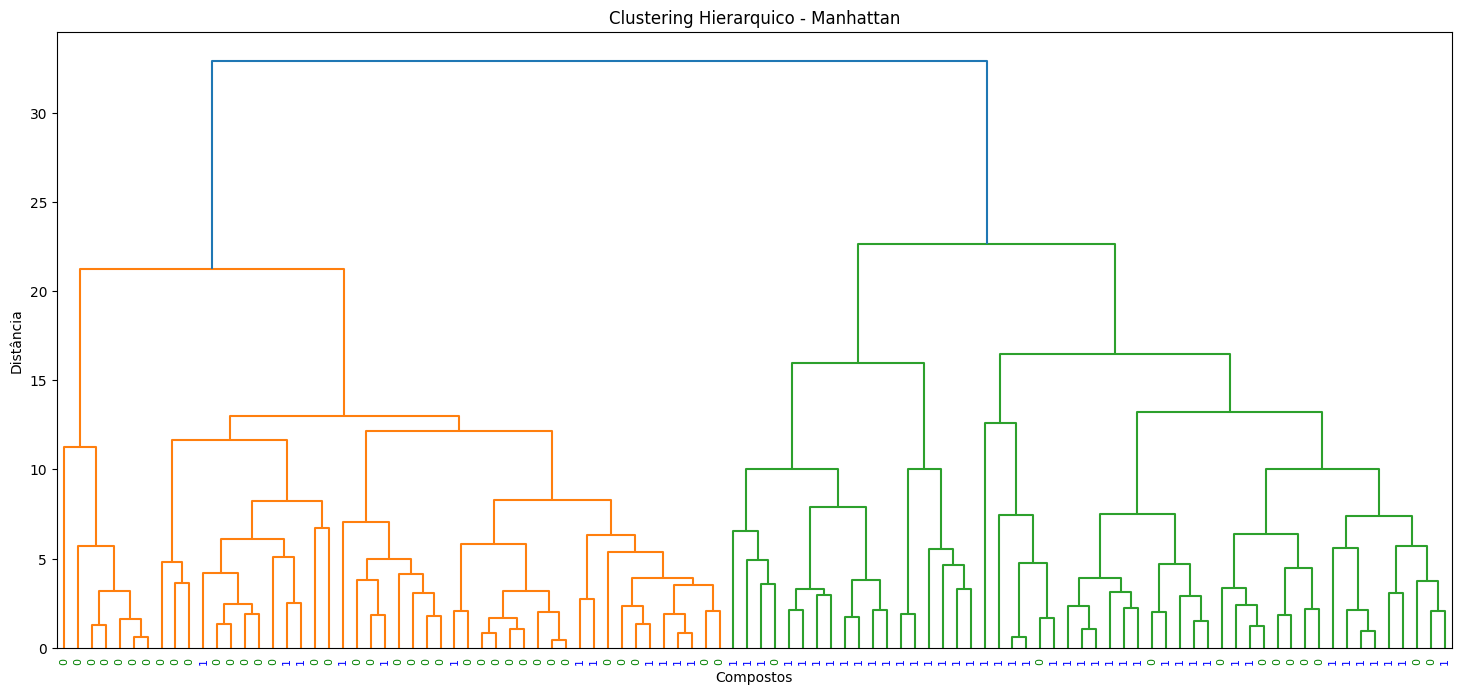

In [359]:
# Clustering hierarquico com distância de manhattan
Z = linkage(sampled_data, method='complete', metric='cityblock')

# dendograma
plt.figure(figsize=(18, 8))
dendrogram(Z, 
           labels=sampled_data['Y'].values, 
           orientation='top', 
           leaf_font_size=8)


# mapa de cores
data_colors = {'0': 'green', '1': 'blue'}
ax = plt.gca()
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(data_colors[lbl.get_text()])



plt.title('Clustering Hierarquico - Manhattan')
plt.xlabel('Compostos')
plt.ylabel('Distância')
plt.show()

### 4.6 - Clustering (K-means)
</p>
<div style="text-align: justify">
Posteriormente, implementou-se outro algoritmo de clustering o K-means, que tem como objectivo minimizar a soma das distâncias entre cada ponto de dados e seu centróide correspondente. Em semelhança à distribuição dos dados nos clusters anteriores, o primeiro cluster obteve uma percentagem superior (72%) de compostos mutagénicos, enquanto o segundo cluster é mais equilibrado.
</div> 

In [405]:
df_copy1 = df.copy()
df_copy1.reset_index(drop=True, inplace=True)

#elbow method
wcss = list()
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)




c:\Users\Paulo Seixal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Paulo Seixal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Paulo Seixal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Paulo Seixal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

Y,0,1
clusters,,
0,717,1937
1,2582,2037


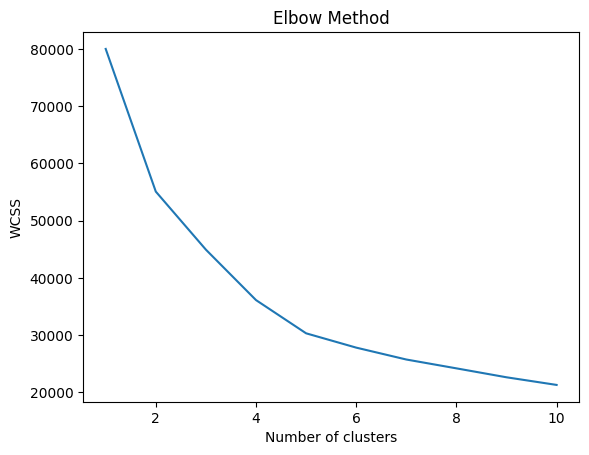

In [403]:
#Criação do plot Elbow Method
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

De modo a escolher o valor ótimo de clusters (k) através do 'elbow method', construiu-se o gráfico anterior. O valor ótimo de k será o 'elbow point' ou seja, o local onde se dá uma mudança acentuada no declive da curva.

No entanto, apesar de termos considerado o valor de k=2, este método torna-se algo subjetivo, uma vez que não há um local óbivo de inflexão da curva

In [419]:
# k-means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_scaled)
labels_k = kmeans.labels_
centroids = kmeans.cluster_centers_

pd.crosstab(labels_k,df_copy1['Y'], rownames=['clusters'] )

c:\Users\Paulo Seixal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Y,0,1
clusters,,
0,717,1937
1,2582,2037


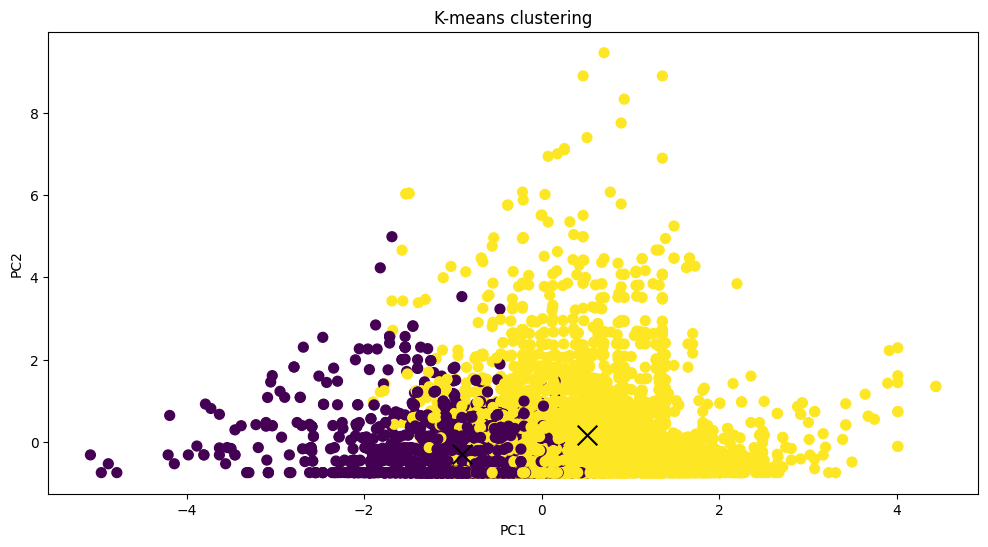

In [420]:
#plot K-means clustering
plt.figure(figsize=(12, 6))
plt.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=labels_k, s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, c='black')
plt.title('K-means clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### 5 - Seleção de moléculas com potencial terapêutico

</p>
<div style="text-align: justify">
Existem várias regras e filtros que podem ser usados para selecionar moléculas com potencial terapêutico. Algumas das abordagens mais comuns incluem as regras de Lipinski, Ghose e Veber, que foram desenvolvidas para ajudar a identificar moléculas com propriedades farmacocinéticas favoráveis.</div> 
</p>
<div style="text-align: justify">
Nesta secção, pretende-se analisar se os compostos que obdecem a estes conjunto de regras e filtros são não mutagénicos. De modo a compreender se algum destes parâmetros poderá facilitar a previsão da mutagenicidade.  </div>

</p>
<div style="text-align: justify">
Para definir cada regra e filtro tendo em conta os descritores fornecidos, é necessário compreender os critérios de cada um.
A Regra de Lipinski é uma das abordagens mais conhecidas. Ela estabelece que, para uma molécula ser um possível fármaco, ela deve atender aos seguintes critérios:
</div>
</p>

- Peso molecular inferior a 500 daltons.</p>
- LogP (coeficiente de partição octanol-água) menor ou igual a 5.</p>
- Menos de cinco dadores de hidrogénio ligados ao nitrogénio ou oxigénio.</p>
- Menos de dez recetores de hidrogênio.</p>

</p>
<div style="text-align: justify">
A Regra de Ghose é outra abordagem comum para selecionar moléculas com potencial terapêutico. Esta regra estabelece que, para uma molécula ser um possível fármaco, a mesma deve atender aos seguintes critérios:</div>
</p>

 - Peso molecular entre 160 e 480 daltons.
 - LogP (coeficiente de partição octanol-água) entre -0,4 e 5,6.
 - Menos de dez átomos de hidrogénio ligados ao nitrogénio.
 - Menos de 12 átomos de hidrogénio ligados ao carbono alifático.

</p>
<div style="text-align: justify">
A Regra de Veber é outra abordagem comum para selecionar moléculas com potencial terapêutico. Essa regra estabelece que, para uma molécula ser um possível fármaco, ela deve atender aos seguintes critérios:
</div>
</p>

 - Não mais que dez ligações rotativas.
 - Não mais que dez doadores ou aceitadores de ligações de hidrogénio.
 - O tamanho máximo do anel não deve exceder oito átomos.
 - O número de átomos de oxigénio e nitrogénio não deve exceder um terço do número total de átomos na molécula.

</p>
<div style="text-align: justify">
As regras e filtros apresentadas são apenas algumas das abordagens comuns para selecionar moléculas com potencial terapêutico.

In [362]:
def get_descriptors(df):
    df['h_bond_donor'] = df['ROMol'].apply(lambda mol: Descriptors.NumHDonors(mol))
    df['h_bond_acceptors'] = df['ROMol'].apply(lambda mol: Descriptors.NumHAcceptors(mol))
    df['rotatable_bonds'] = df['ROMol'].apply(lambda mol: Descriptors.NumRotatableBonds(mol))
    df['number_of_atoms'] = df['ROMol'].apply(lambda mol: Chem.rdchem.Mol.GetNumAtoms(mol))
    df['molar_refractivity'] = df['ROMol'].apply(lambda mol: Chem.Crippen.MolMR(mol))
    df['topological_surface_area_mapping'] = df['ROMol'].apply(lambda mol: Chem.QED.properties(mol).PSA)
    df['formal_charge'] = df['ROMol'].apply(lambda mol: Chem.rdmolops.GetFormalCharge(mol))
    df['heavy_atoms'] = df['ROMol'].apply(lambda mol: Chem.rdchem.Mol.GetNumHeavyAtoms(mol))
    df['num_of_rings'] = df['ROMol'].apply(lambda mol: Chem.rdMolDescriptors.CalcNumRings(mol))
    return df 
    
def score(df):
    
    results = {
        "lipinski_rule": [0]*df.shape[0],
        "ghose_filter": [0]*df.shape[0],
        "veber_filter": [0]*df.shape[0],
        "three_filter": [0]*df.shape[0],
        "reos_filter": [0]*df.shape[0],
        "drug_like_filter":[0]*df.shape[0],
        "pass_all": [0]*df.shape[0]}
    
    for i, row in df.iterrows():
        MW = row['MW']
        logP = row['logP']
        h_bond_donor = row['h_bond_donor']
        h_bond_acceptors = row['h_bond_acceptors']
        rotatable_bonds = row['rotatable_bonds']
        number_of_atoms = row['number_of_atoms']
        molar_refractivity = row['molar_refractivity']
        topological_surface_area_mapping = row['topological_surface_area_mapping']
        formal_charge = row['formal_charge']
        heavy_atoms = row['heavy_atoms']
        num_of_rings = row['num_of_rings']
        
        # Lipinski
        if MW <= 500 and logP <= 5 and h_bond_donor <= 5 and h_bond_acceptors <= 10 and rotatable_bonds <= 5:
            results["lipinski_rule"][i] = 1

        # Ghose Filter
        if MW >= 160 and MW <= 480 and logP >= -0.4 and logP <= 5.6 and number_of_atoms >= 20 and number_of_atoms <= 70 and molar_refractivity >= 40 and molar_refractivity <= 130:
            results["ghose_filter"][i] = 1

        # Veber Filter
        if rotatable_bonds <= 10 and topological_surface_area_mapping <= 140:
            results["veber_filter"][i] = 1

        # Rule of 3
        if MW <= 300 and logP <= 3 and h_bond_donor <= 3 and h_bond_acceptors <= 3 and rotatable_bonds <= 3:
            results["three_filter"][i] = 1

        # REOS Filter
        if MW >= 200 and MW <= 500 and logP >= int(0 - 5) and logP <= 5 and h_bond_donor >= 0 and h_bond_donor <= 5 and h_bond_acceptors >= 0 and h_bond_acceptors <= 10 and formal_charge >= int(0-2) and formal_charge <= 2 and rotatable_bonds >= 0 and rotatable_bonds <= 8 and heavy_atoms >= 15 and heavy_atoms <= 50:
            results["reos_filter"][i] = 1

        #Drug Like Filter
        if MW < 400 and num_of_rings > 0 and rotatable_bonds < 5 and h_bond_donor <= 5 and h_bond_acceptors <= 10 and logP < 5:
            results["drug_like_filter"][i] = 1
        
        f = 0 
        for key, value in results.items():
            if results[key][i] == 1:
                f += 1
        if f == 6: 
            results["pass_all"][i] = 1 
        df_filters = pd.DataFrame.from_dict(results)
    return df_filters

get_descriptors(df)
df_filters = score(df)
print(df_filters)

      lipinski_rule  ghose_filter  veber_filter  three_filter  reos_filter  \
0                 0             1             1             0            0   
1                 0             1             1             0            0   
2                 0             0             1             0            0   
3                 1             0             1             1            0   
4                 1             0             1             1            0   
...             ...           ...           ...           ...          ...   
7268              0             0             0             0            0   
7269              1             0             1             0            1   
7270              1             0             1             0            0   
7271              1             0             1             1            0   
7272              0             0             1             0            0   

      drug_like_filter  pass_all  
0                    0      

</p>
<div style="text-align: justify">Após aplicação das regras e filtros a cada um dos compostos, verificou-se que 27 dos compostos cumprem os critérios, sendo eles os descritos de seguida. </div>

In [363]:
if (df_filters['pass_all'] == 1).any():
    print('{} compostos cumprem os critérios de todos os filtros'.format(df[df_filters['pass_all'] == 1].shape[0]))
else: print('Nenhum composto')

27 compostos cumprem os critérios de todos os filtros


In [364]:
df[df_filters['pass_all'] == 1][['ids', 'Y']]

,ids,Y
377,Drug 378,1
474,Drug 475,1
666,Drug 667,1
932,Drug 933,0
1428,Drug 1429,1
1546,Drug 1547,1
1864,Drug 1865,1
2116,Drug 2117,1
2595,Drug 2596,1
2640,Drug 2641,1


#### Filtros vs Mutagenicidade

In [365]:
filters_y = pd.concat([df['Y'], df_filters], axis=1)
filters_y

,Y,lipinski_rule,ghose_filter,veber_filter,three_filter,reos_filter,drug_like_filter,pass_all
0,1,0,1,1,0,0,0,0
1,1,0,1,1,0,0,0,0
2,0,0,0,1,0,0,0,0
3,1,1,0,1,1,0,0,0
4,1,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...
7268,0,0,0,0,0,0,0,0
7269,0,1,0,1,0,1,1,0
7270,0,1,0,1,0,0,0,0
7271,0,1,0,1,1,0,1,0


</p>
<div style="text-align: justify"> Realizou-se um teste qui-quadrado para determinar se há uma associação estatisticamente significativa entre as variáveis binárias (Mutagenicidade e Filtros).</div>
</p>
<div style="text-align: justify">
Em todos os casos o valor de p-value é muito menor que 0.05, isso significa que há evidências estatísticas significativas de que a distribuição de frequência observada nos dados é diferente da distribuição de frequência esperada. Em outras palavras, há uma associação significativa entre as variáveis categóricas testadas.
</div>

In [366]:
lipinski_table = pd.crosstab(filters_y['Y'],filters_y['lipinski_rule'])
stat, p, dof, expected = chi2_contingency(lipinski_table)
print("Chi-square = ", stat)
print("p-value = ", p)
print("Graus de Liberdade = ", dof)

Chi-square =  15.949762641620936
p-value =  6.504593455869497e-05
Graus de Liberdade =  1


In [367]:
ghose_table = pd.crosstab(filters_y['Y'],filters_y['ghose_filter'])
stat, p, dof, expected = chi2_contingency(ghose_table)
print("Chi-square = ", stat)
print("p-value = ", p)
print("Graus de Liberdade = ", dof)

Chi-square =  25.70179385478958
p-value =  3.9845650760378914e-07
Graus de Liberdade =  1


In [368]:
veber_filter = pd.crosstab(filters_y['Y'],filters_y['veber_filter'])
stat, p, dof, expected = chi2_contingency(veber_filter)
print("Chi-square = ", stat)
print("p-value = ", p)
print("Graus de Liberdade = ", dof)

Chi-square =  45.57579531857671
p-value =  1.4684501852310006e-11
Graus de Liberdade =  1


In [369]:
three_filter = pd.crosstab(filters_y['Y'],filters_y['three_filter'])
stat, p, dof, expected = chi2_contingency(three_filter)
print("Chi-square = ", stat)
print("p-value = ", p)
print("Graus de Liberdade = ", dof)

Chi-square =  60.511048293685576
p-value =  7.316666556328223e-15
Graus de Liberdade =  1


In [370]:
reos_filter = pd.crosstab(filters_y['Y'],filters_y['reos_filter'])
stat, p, dof, expected = chi2_contingency(reos_filter)
print("Chi-square = ", stat)
print("p-value = ", p)
print("Graus de Liberdade = ", dof)

Chi-square =  78.50846993860289
p-value =  7.965597142915431e-19
Graus de Liberdade =  1


In [371]:
drug_like_filter = pd.crosstab(df['Y'],df_filters['drug_like_filter'])
stat, p, dof, expected = chi2_contingency(drug_like_filter)
print("Chi-square = ", stat)
print("p-value = ", p)
print("Graus de Liberdade = ", dof)

Chi-square =  56.3503613335554
p-value =  6.064213012102592e-14
Graus de Liberdade =  1


</p>
<div style="text-align: justify"> De modo a identificar possiveis relações entre as variáveis binárias , determinou-se as respetivas correlações.
Olhando para a matriz, podemos observar que há algumas correlações positivas moderadas entre lipinski_rule e drug_like_filter (0.66), reos_filter e ghose_filter (0.45), e reos_filter e drug_like_filter (0.3). Há também algumas correlações negativas moderadas, como entre ghose_filter e three_filter (-0.36) e three_filter e reos_filter (-0.43).</div>
</p>
<div style="text-align: justify">
No entanto, em geral, as correlações entre essas variáveis são bastante fracas (próximas de 0), o que sugere que elas não estão fortemente relacionadas umas com as outras. Portanto, é possível que cada variável contribua de forma única para o modelo e que nenhuma delas possa ser descartada sem perda de informação importante.</div>

In [372]:
filters_y_corr = filters_y[['Y','lipinski_rule','ghose_filter','three_filter','reos_filter','drug_like_filter']].corr()
print(filters_y_corr)

                         Y  lipinski_rule  ghose_filter  three_filter  \
Y                 1.000000       0.047162      0.059768     -0.091512   
lipinski_rule     0.047162       1.000000     -0.132354      0.358751   
ghose_filter      0.059768      -0.132354      1.000000     -0.361978   
three_filter     -0.091512       0.358751     -0.361978      1.000000   
reos_filter       0.104178       0.202016      0.452297     -0.433997   
drug_like_filter  0.088305       0.664105     -0.017854      0.157563   

                  reos_filter  drug_like_filter  
Y                    0.104178          0.088305  
lipinski_rule        0.202016          0.664105  
ghose_filter         0.452297         -0.017854  
three_filter        -0.433997          0.157563  
reos_filter          1.000000          0.295366  
drug_like_filter     0.295366          1.000000  


### 6 - Fingerprints

</p>
<div style="text-align: justify">
As "fingerprints" na análise de moléculas SMILES referem-se a códigos numéricos ou binários que são gerados a partir da representação da estrutura molecular da molécula na forma de SMILES.
</div>
</p>
<div style="text-align: justify">
Esses códigos são úteis para descrever a estrutura molecular de uma molécula de forma concisa e eficiente, permitindo a sua rápida identificação e comparação com outras moléculas. Eles podem ser gerados usando uma variedade de algoritmos de codificação e podem incluir informações sobre a topologia molecular, subestruturas, propriedades químicas, entre outros.
</div>
</p>
<div style="text-align: justify">
As fingerprints podem ser usadas em várias aplicações, incluindo a análise de similaridade molecular, virtual screening e modelagem de QSAR (Quantitative Structure-Activity Relationship), onde as propriedades bioativas das moléculas são correlacionadas com suas características estruturais.
</div>
</p>
<div style="text-align: justify">
Deste modo, pretende-se utilizar as "fingerprints" como atributos para a predição da mutagenicidade, em que as selecionadas foram o algoritmo de Morgan, MACCS keys e PubChem. 
</p>
Estes fingerprints serão usados em conjunto com os modelos machine learning a ser usados na segunda fase.
</div>

##### 6.1 - CIRCULAR MORGAN FINGERPRINT
</p>
<div style="text-align: justify">
O algoritmo Morgan usa uma abordagem de vizinhança que considera os átomos adjacentes a um átomo central, bem como os átomos adjacentes a esses átomos, formando um conjunto de anéis (ou "círculos") que circundam o átomo central. A partir desses círculos, o algoritmo cria uma série de vetores binários, que são usados para gerar a Morgan Circular Fingerprint.</div>
</p>
<div style="text-align: justify">
A Morgan Circular Fingerprint é uma representação compacta da estrutura molecular de uma molécula e é frequentemente usada em aplicações de aprendizado de máquina para classificação, agrupamento e previsão de propriedades de moléculas. É particularmente útil na análise de grandes conjuntos de moléculas, pois permite uma análise rápida e eficiente da similaridade estrutural entre elas.</div>

In [373]:
class MFP:

    def __init__(self, fp, names):
        self.fp = fp
        self.names = names
    def __str__(self):
        return "%d bit MFP" % len(self.fp)
    def __len__(self):
        return len(self.fp)

def get_mfp(mol, radius=2, nBits=1024, useFeatures=False, counts=False, dtype=np.float32):
    arr = np.zeros((1,), dtype)
    
    if counts is True:
        info = {}
        fp = AllChem.GetHashedMorganFingerprint(mol, radius, nBits, useFeatures=useFeatures)
        DataStructs.ConvertToNumpyArray(fp, arr)
    else:
        DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures), arr)
    return MFP(arr, range(nBits))

In [374]:
df['MFP'] = df['ROMol'].map(get_mfp)

In [375]:
X = np.array([x.fp for x in df['MFP']])
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

#### t-SNE
</p>
<div style="text-align: justify">
t-SNE (t-distributed stochastic neighbor embedding) é um algoritmo de redução de dimensionalidade usado para visualizar dados de alta dimensão em um espaço de duas ou três dimensões. Este mapeia pontos de dados de alta dimensão para um espaço de baixa dimensão preservando as distâncias entre eles o máximo possível. O t-SNE é especialmente útil para a visualização de dados complexos, onde se inclui os fingerprints.</div>

In [376]:
model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_drugs = model.fit_transform(X)

In [377]:
df['TSNE_C1'] = tsne_drugs.T[0]
df['TSNE_C2'] = tsne_drugs.T[1]

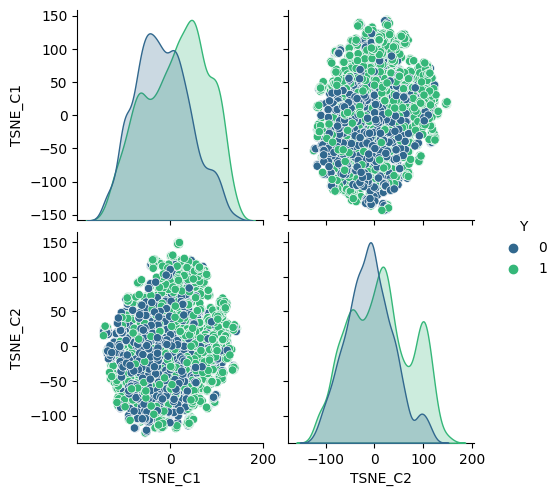

In [378]:
sns.pairplot(df, hue='Y', vars=['TSNE_C1', 'TSNE_C2'], palette='viridis')

#### Análise dos Componentes Principais (PCA)

In [379]:
pca = PCA(n_components=3, random_state=0)
pca_drugs = pca.fit_transform(X)

#obter as percentagens de variabilidade explicadas por cada PC
varia_exp = pca.explained_variance_ratio_
matriz_var_exp = np.diag(varia_exp*100)
print(matriz_var_exp)

[[5.170947  0.        0.       ]
 [0.        3.474958  0.       ]
 [0.        0.        2.9210973]]


In [380]:
df['pc1'] = pca_drugs.T[0]
df['pc2'] = pca_drugs.T[1]
df['pc3'] = pca_drugs.T[2]

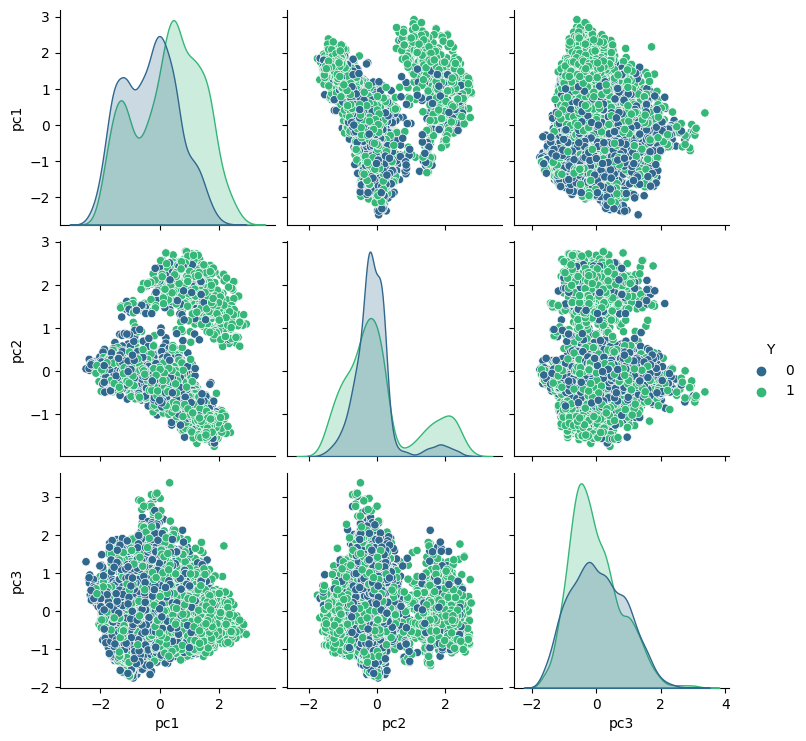

In [381]:
sns.pairplot(df, hue='Y', vars=['pc1', 'pc2', 'pc3'], palette='viridis')

No caso de dados de alta dimensionalidade, recomenda-se reduzir o número de dimensões com outro método antes de prosseguir com o t-SNE.

In [382]:
pca_model = PCA(n_components=30, random_state=0)
tsne_model = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=5000)
tsne_pca = tsne_model.fit_transform(pca_model.fit_transform(X))

In [383]:
df['tsne_pca1'] = tsne_pca.T[0]
df['tsne_pca2'] = tsne_pca.T[1]

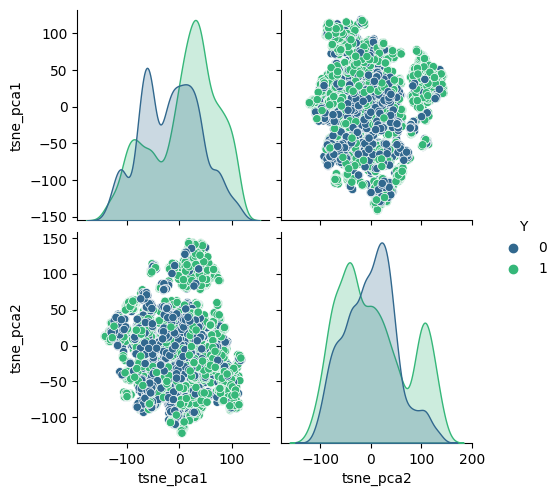

In [384]:
sns.pairplot(df, hue='Y', vars=['tsne_pca1', 'tsne_pca2' ], palette='viridis')

##### 6.2 - MACCS KEY FINGERPRINT
</p>
<div style="text-align: justify">
A MACCS Key Fingerprint é composta por um conjunto fixo de chaves binárias (bits) que representam a presença ou ausência de cada uma das subestruturas moleculares selecionadas. Essas subestruturas são derivadas de um conjunto de regras de estruturação desenvolvidas para incluir grupos funcionais comuns em moléculas bioativas.</div>

In [385]:
# Gera os MACCS fingerprints para cada molécula e adiciona ao df 
def maccs(mol):
    return MACCSkeys.GenMACCSKeys(mol)
df['maccs'] = df['smiles'].apply(lambda x: maccs(Chem.MolFromSmiles(x)))    

In [386]:
# calcula a matriz de similaridade dos fingerprints
mols = df['ROMol']
fps = [AllChem.GetMACCSKeysFingerprint(mol) for mol in mols]
similarity_matrix = np.zeros((len(mols), len(mols)))
for i in range(len(mols)):
    for j in range(i, len(mols)):
        similarity = DataStructs.FingerprintSimilarity(fps[i], fps[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity
print(similarity_matrix)

[[1.         0.75       0.33333333 ... 0.15384615 0.08       0.30357143]
 [0.75       1.         0.22       ... 0.17307692 0.1        0.27586207]
 [0.33333333 0.22       1.         ... 0.07407407 0.18181818 0.33962264]
 ...
 [0.15384615 0.17307692 0.07407407 ... 1.         0.20930233 0.22413793]
 [0.08       0.1        0.18181818 ... 0.20930233 1.         0.2745098 ]
 [0.30357143 0.27586207 0.33962264 ... 0.22413793 0.2745098  1.        ]]


In [387]:
# Realiza a PCA para reduzir a dimensionalidade dos dados
pca = PCA(n_components=2)
pca_data = pca.fit_transform(similarity_matrix)

In [388]:
# Realiza o clustering hierárquico na matriz de similaridade
hierarchical_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
labels_hc = hierarchical_clustering.fit_predict(pca_data)

c:\Users\Paulo Seixal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


c:\Users\Paulo Seixal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


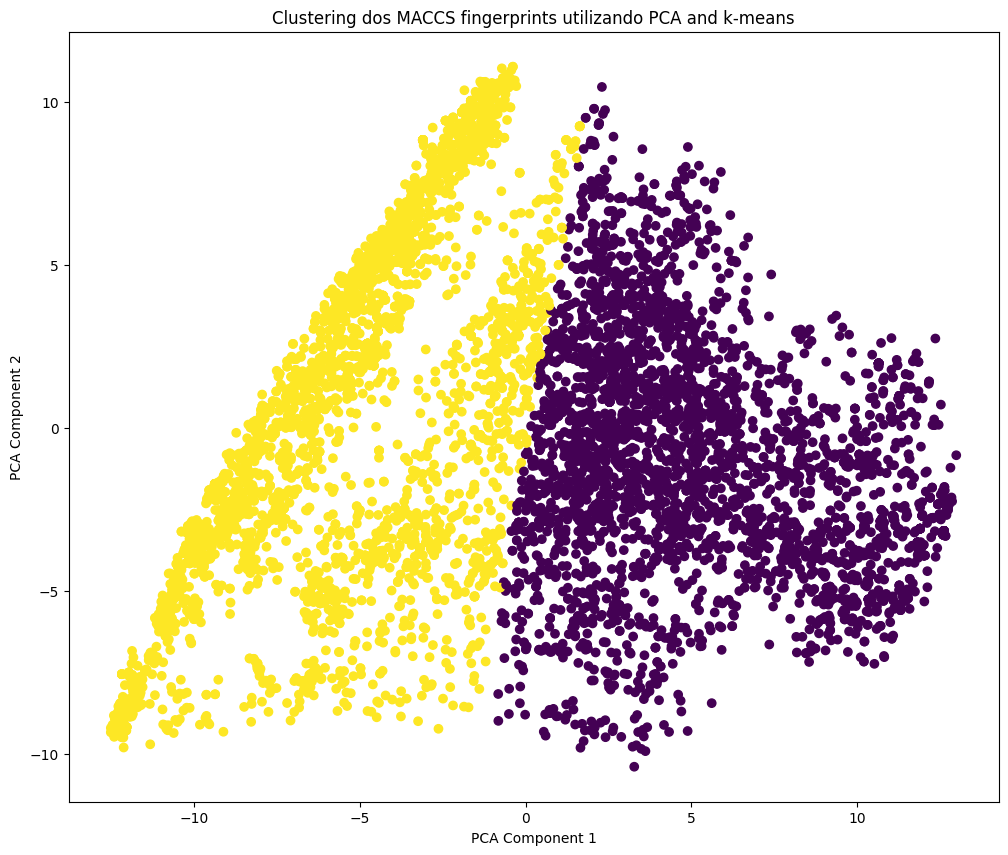

In [389]:
# Realiza o k-means clustering com k=3
kmeans = KMeans(n_clusters=2, random_state=0).fit(pca_data)
labels = kmeans.labels_
plt.figure(figsize=(12, 10))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels, cmap='viridis')
plt.title('Clustering dos MACCS fingerprints utilizando PCA and k-means')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

##### 6.3 - PubChem Fingerprinting
</p>
<div style="text-align: justify">
O sistema PubChem tem como função a criação de uma subestrutura binária 'fingerprint' para esturuturas químicas. Estas 'fingerprints' são usadas na base de dados PubChem para a procura de similariedade entre vizinhos e na pesquisa. </div>
</p>
<div style="text-align: justify">
Cada fragmento de uma estrutura química é representado pela substrutura. O 'fingerprint' é uma lista binária (bits) ordenada (1 ou 0). Cada bit representa a determinação boleana para a presença de uma característica química estrutural.</div>
</p>
<div style="text-align: justify">
Neste momento PubChem fingerprints tem 881 bits, armazenando 880 características estruturais.</div> 

In [390]:
# gera as representações de PubChem Fingerprinting
mol = df['ROMol']
df['ap_fingerprint'] = df['ROMol'].apply(lambda mol: GetHashedAtomPairFingerprintAsBitVect(mol))
df['tt_fingerprint'] = df['ROMol'].apply(lambda mol: GetHashedTopologicalTorsionFingerprintAsBitVect(mol))

# exibe as representações de PubChem Fingerprinting
print('Atom Pair Fingerprint:')
print(df['ap_fingerprint'])

print('Topological Torsion Fingerprint:')
print(df['tt_fingerprint'])

Atom Pair Fingerprint:
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...
3       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
7268    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7269    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7270    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7271    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7272    [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: ap_fingerprint, Length: 7273, dtype: object
Topological Torsion Fingerprint:
0       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...
1       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...
3       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4       [0, 0, 0, 0, 0, 

#### Análise dos Componentes Principais (PCA)

In [391]:
# Criar uma matriz a partir dos fingerprints
ap_fps = np.array([np.frombuffer(bytes(fp.ToBitString(), 'utf-8'), dtype=np.uint8) for fp in df['ap_fingerprint']])
tt_fps = np.array([np.frombuffer(bytes(fp.ToBitString(), 'utf-8'), dtype=np.uint8) for fp in df['tt_fingerprint']])

# Padronizar os dados
ap_fps = StandardScaler().fit_transform(ap_fps)
tt_fps = StandardScaler().fit_transform(tt_fps)

In [392]:
# Aplicar PCA aos dados padronizados

pca = PCA(n_components=2)
ap_pca = pca.fit_transform(ap_fps)
tt_pca = pca.fit_transform(tt_fps)

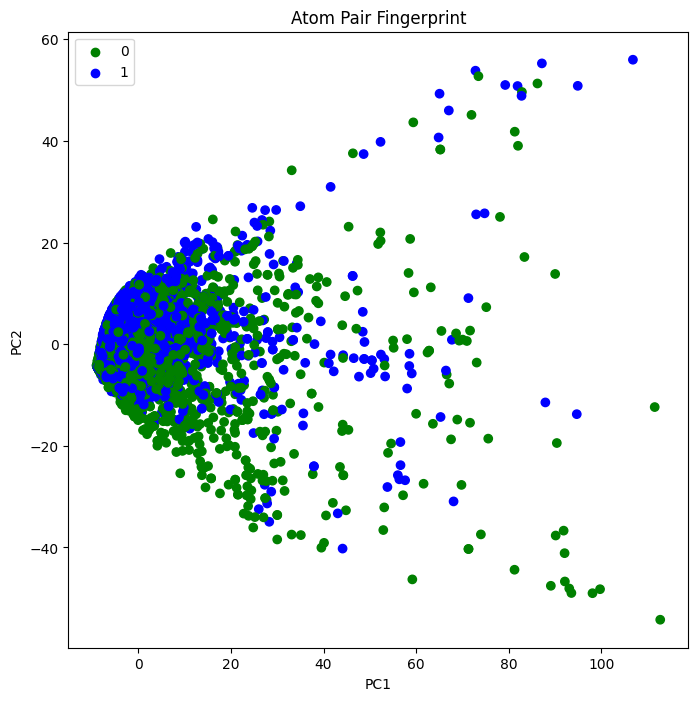

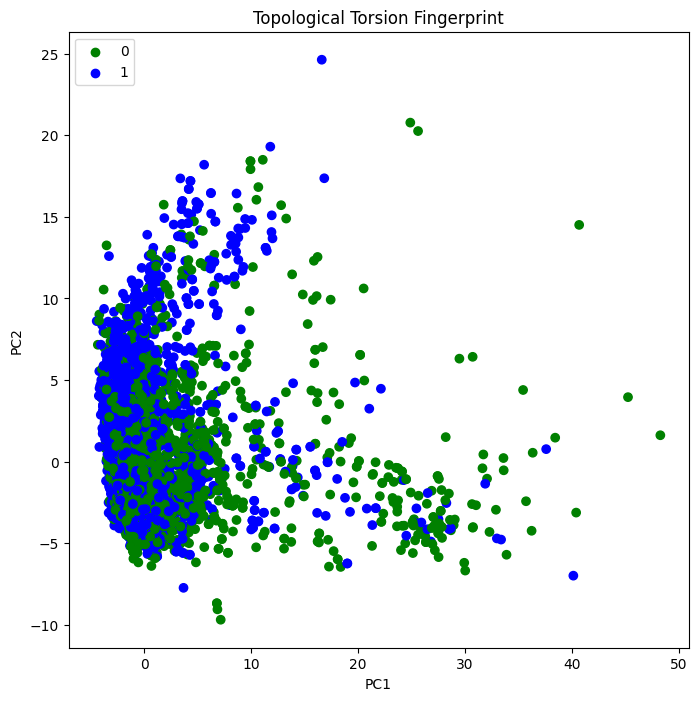

In [393]:
%matplotlib inline
# mapa de cores para o plot
data_colors = {0: 'green', 1: 'blue'}
colors = [data_colors[t] for t in df['Y']]

# plot
plt.figure(figsize=(8, 8))
plt.scatter(ap_pca[:, 0], ap_pca[:, 1], c=colors)
plt.title('Atom Pair Fingerprint')
plt.xlabel('PC1')
plt.ylabel('PC2')

# legenda
handles = []
labels = []
for data_type, color in data_colors.items():
    handles.append(plt.scatter([], [], c=color))
    labels.append(data_type)# legenda
plt.legend(handles, labels, loc='upper left')

plt.figure(figsize=(8, 8))
plt.scatter(tt_pca[:, 0], tt_pca[:, 1], c=colors)
plt.title('Topological Torsion Fingerprint')
plt.xlabel('PC1')
plt.ylabel('PC2')

# legenda
handles = []
labels = []
for data_type, color in data_colors.items():
    handles.append(plt.scatter([], [], c=color))
    labels.append(data_type)# legenda
plt.legend(handles, labels, loc='upper left')


In [76]:
print(df.keys())

Index(['ids', 'smiles', 'Y', 'ROMol', 'MW', 'logP', 'h_bond_donor',
       'h_bond_acceptors', 'rotatable_bonds', 'number_of_atoms',
       'molar_refractivity', 'topological_surface_area_mapping',
       'formal_charge', 'heavy_atoms', 'num_of_rings', 'MFP', 'TSNE_C1',
       'TSNE_C2', 'pc1', 'pc2', 'pc3', 'tsne_pca1', 'tsne_pca2', 'maccs',
       'ap_fingerprint', 'tt_fingerprint'],
      dtype='object')


# 7 - Referências

[1] Xu, Congying, et al. “In silico prediction of chemical Ames mutagenicity.” Journal of chemical information and modeling 52.11 (2012): 2840-2847.

[2] Benigni, R.; Giuliani, A. Computer-assisted analysis of interlaboratory Ames test variability. J. Toxicol. Environ. Health 1988, 25, 135−148.

[3]  Hansen, K.; Mika, S.; Schroeter, T.; Sutter, A.; ter Laak, A.; Steger-Hartmann, T.; Heinrich, N.; Muller, K. R. Benchmark data set for in silico prediction of Ames mutagenicity. J. Chem. Inf. Model. 2009, 49, 2077−2081.